<a href="https://colab.research.google.com/github/MATHONSIMM/Capstone-Project-Group-11192/blob/main/Final_Captone_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Downloads**

In [ ]:
# libraries update
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


# **Libraries**

In [ ]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.covariance import LedoitWolf
from IPython.display import display
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import random
import tensorflow as tf





# **Initializer**

In [ ]:

# Project folders
PROJECT_ROOT = Path(".").resolve()
DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)

print("Python:", sys.version.split()[0])
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)
print("Project root:", PROJECT_ROOT)
print("Data dir:", DATA_DIR)


Python: 3.12.12
Pandas: 2.2.2
Numpy: 2.0.2
Project root: /content
Data dir: /content/data


#**ETFs Data**

##**Download ETF prices**

In [ ]:
try:
    import yfinance as yf
except ModuleNotFoundError:
    print("yfinance not found, installing...")
    !pip install yfinance --quiet
    import yfinance as yf

SECTOR_TICKERS = {
    "STX40.JO": "Top40",
    "STXDIV.JO": "Dividend",
    "STXFIN.JO": "Financials",
    "STXIND.JO": "Industrials",
    "STXRES.JO": "Resources",
}

START_DATE = "2008-01-01"
END_DATE   = "2025-01-01"

print("Universe tickers:", SECTOR_TICKERS)
print("Start date:", START_DATE)
print("End date:", END_DATE)


Universe tickers: {'STX40.JO': 'Top40', 'STXDIV.JO': 'Dividend', 'STXFIN.JO': 'Financials', 'STXIND.JO': 'Industrials', 'STXRES.JO': 'Resources'}
Start date: 2008-01-01
End date: 2025-01-01


In [ ]:
def load_etf_prices(tickers, start, end, cache_path):
    """
    Download ETF adjusted close prices from Yahoo Finance.
    If cache_path exists, load from there instead.
    """
    cache_path = Path(cache_path)

    if cache_path.exists():
        print(f"Loading cached ETF prices from: {cache_path}")
        # Instead of ETFtickers, use tickers.keys()
        prices = pd.read_csv(cache_path, index_col=0, parse_dates=True)
        return prices

    print("Downloading ETF prices from Yahoo Finance...")

    data = yf.download(
        tickers=list(tickers.keys()),  # <-- FIXED
        start=start,
        end=end,
        progress=False
    )

    if isinstance(data, pd.Series):
        data = data.to_frame()

    prices = data["Close"].copy()
    prices = prices.dropna(how="all")

    prices.to_csv(cache_path)
    print(f"Saved ETF prices to cache: {cache_path}")

    return prices

ETF_CACHE_PATH = DATA_DIR / "etf_prices.csv"

etf_prices = load_etf_prices(
    tickers=SECTOR_TICKERS,
    start=START_DATE,
    end=END_DATE,
    cache_path=ETF_CACHE_PATH
)

etf_prices.tail()

/tmp/ipython-input-2821243266.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(


Saved ETF prices to cache: /content/data/etf_prices.csv


Ticker,STX40.JO,STXDIV.JO,STXFIN.JO,STXIND.JO,STXRES.JO
Date,,,,,
2024-12-23,7649.868652,267.854980,2103.050293,11781.784180,5480.097656
2024-12-24,7697.855957,266.855530,2117.044189,11843.773438,5564.083984
2024-12-27,7661.865234,264.856659,2095.053711,11846.773438,5515.091797
2024-12-30,7602.881836,264.856659,2087.057617,11705.799805,5426.106934
2024-12-31,7604.881836,265.856049,2083.059570,11756.789062,5433.105469


##**Plot ETF prices**

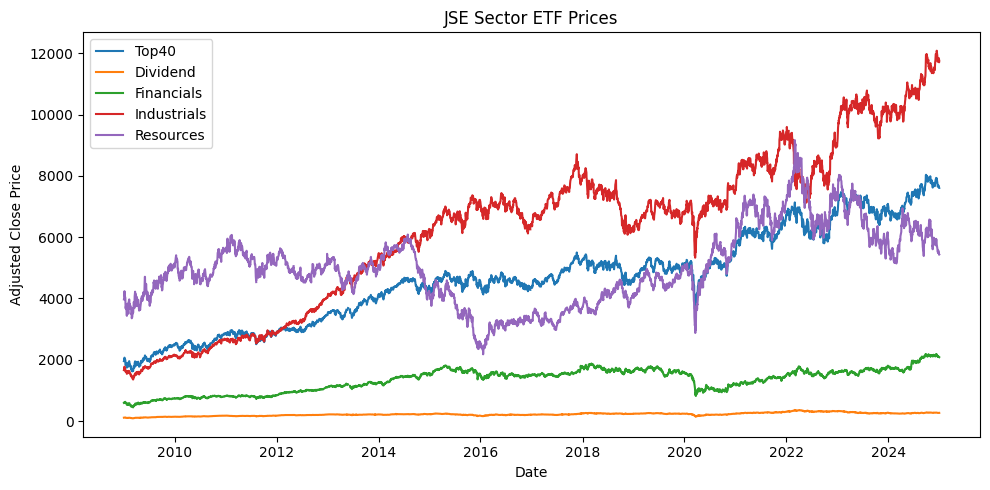

In [ ]:

if isinstance(etf_prices, pd.Series):
    etf_prices = etf_prices.to_frame(name=list(SECTOR_TICKERS.values())[0])

plt.figure(figsize=(10, 5))

for ticker, sector_name in SECTOR_TICKERS.items():
    if ticker in etf_prices.columns:
        plt.plot(etf_prices.index, etf_prices[ticker], label=sector_name)

plt.title("JSE Sector ETF Prices")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.tight_layout()
plt.show()


## **Compute QUARTERLY log returns (focus of the study)**

In [ ]:

etf_prices_named = etf_prices.rename(columns=SECTOR_TICKERS)

# daily log returns
log_returns_daily = np.log(etf_prices_named / etf_prices_named.shift(1))

# aggregate to QUARTERLY log returns (sum of daily logs per quarter)
quarterly_returns = log_returns_daily.resample("Q").sum().dropna()

print("Quarterly returns shape:", quarterly_returns.shape)
quarterly_returns.head()


Quarterly returns shape: (64, 5)


/tmp/ipython-input-3578524612.py:7: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_returns = log_returns_daily.resample("Q").sum().dropna()


Ticker,Top40,Dividend,Financials,Industrials,Resources
Date,,,,,
2009-03-31,-0.065146,-0.082299,-0.091889,-0.093147,-0.035877
2009-06-30,0.047973,0.104743,0.098453,0.121176,0.027343
2009-09-30,0.123004,0.165955,0.129989,0.138358,0.107224
2009-12-31,0.114813,0.035019,0.057031,0.087786,0.145574
2010-03-31,0.033284,0.069566,0.090587,0.032783,0.019525


## **Summary statistics and correlation of quarterly returns**

Summary statistics for quarterly log returns:



,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
Top40,64.0,0.021681,0.072389,-0.215237,-0.022461,0.027402,0.066905,0.207770
Dividend,64.0,0.013210,0.091879,-0.388903,-0.033751,0.014325,0.067156,0.210036
Financials,64.0,0.020732,0.103629,-0.519986,-0.020708,0.022809,0.089593,0.209995
Industrials,64.0,0.031491,0.070700,-0.129984,-0.019571,0.032717,0.084360,0.170390
Resources,64.0,0.004257,0.115344,-0.289223,-0.066203,0.013108,0.069398,0.323606



Correlation matrix between sectors:



Ticker,Top40,Dividend,Financials,Industrials,Resources
Ticker,,,,,
Top40,1.000000,0.740167,0.713017,0.808191,0.771450
Dividend,0.740167,1.000000,0.834690,0.455414,0.691162
Financials,0.713017,0.834690,1.000000,0.449387,0.486031
Industrials,0.808191,0.455414,0.449387,1.000000,0.361665
Resources,0.771450,0.691162,0.486031,0.361665,1.000000


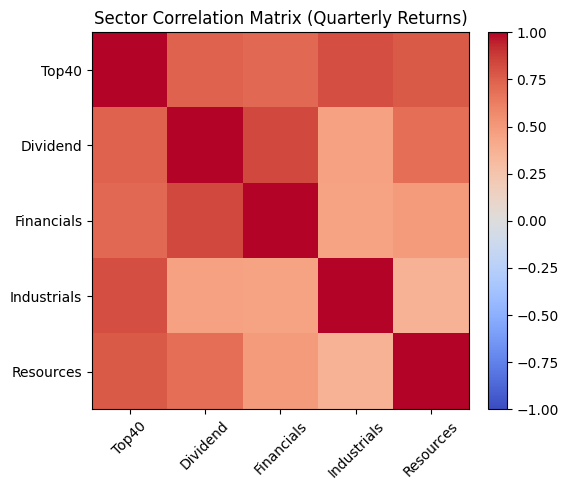

In [ ]:
# Descriptive statistics (per sector)
summary_stats = quarterly_returns.describe().T

print("Summary statistics for quarterly log returns:\n")
display(summary_stats)

# Correlation matrix between sectors
corr_matrix = quarterly_returns.corr()

print("\nCorrelation matrix between sectors:\n")
display(corr_matrix)

# Correlation heatmap
plt.figure(figsize=(6, 5))
im = plt.imshow(corr_matrix.values, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)

plt.xticks(ticks=range(len(corr_matrix.columns)), labels=corr_matrix.columns, rotation=45)
plt.yticks(ticks=range(len(corr_matrix.index)), labels=corr_matrix.index)

plt.title("Sector Correlation Matrix (Quarterly Returns)")
plt.tight_layout()
plt.show()


#**Macroeconomic Data**

## **Initialization**

In [ ]:
quarterly_index = quarterly_returns.index

print("Quarterly index (to be used for all macro features):")
display(quarterly_index)

macro_features = {}

def align_to_quarterly(data_series, name):
    """
    Align a macro time series to the quarterly index.
    Forward fills missing values and keeps only matching quarters.
    """

    s = data_series.copy()

    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index)

    if s.index.freq is None or s.index.freq != "Q":
        s = s.resample("Q").last()

    s = s.reindex(quarterly_index)

    s = s.ffill()

    macro_features[name] = s
    return s

print("\nMacro feature framework is ready.")


Quarterly index (to be used for all macro features):


DatetimeIndex(['2009-03-31', '2009-06-30', '2009-09-30', '2009-12-31',
               '2010-03-31', '2010-06-30', '2010-09-30', '2010-12-31',
               '2011-03-31', '2011-06-30', '2011-09-30', '2011-12-31',
               '2012-03-31', '2012-06-30', '2012-09-30', '2012-12-31',
               '2013-03-31', '2013-06-30', '2013-09-30', '2013-12-31',
               '2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31',
               '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
               '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31',
               '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31',
               '2018-03-31', '2018-06-30', '2018-09-30', '2018-12-31',
               '2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31',
               '2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31',
               '2021-03-31', '2021-06-30', '2021-09-30', '2021-12-31',
               '2022-03-31', '2022-06-30', '2022-09-30', '2022-12-31',
      


Macro feature framework is ready.


## **Extraction and Alignment to ETF data**

In [ ]:
try:
    from fredapi import Fred
except ModuleNotFoundError:
    print("fredapi not found, installing...")
    !pip install fredapi --quiet
    from fredapi import Fred

try:
    import gdown
except ModuleNotFoundError:
    print("gdown not found, installing...")
    !pip install gdown --quiet
    import gdown

# FRED macro data: CPI, GDP, 10-year SAGB yield
fred = Fred(api_key='db781b238641fc185968ecffff81be38')

start_macro = '2008-01-01'
end_macro   = '2025-09-30'

cpi  = fred.get_series('ZAFCPIALLMINMEI', start_macro, end_macro)   # CPI (monthly)
gdp  = fred.get_series('NGDPRSAXDCZAQ',   start_macro, end_macro)   # GDP (quarterly)
zagb = fred.get_series('IRLTLT01ZAM156N', start_macro, end_macro)   # 10-year SAGB yield (monthly)

Freddata = pd.concat([cpi, gdp, zagb], axis=1)
Freddata.columns = ['CPI', 'GDP', "ZAGB10y"]
Freddata = Freddata.dropna()

print("Raw FRED data (CPI, GDP, ZAGB10y):")
display(Freddata.tail())

# Align each FRED series to our quarterly index and store in macro_features
for col in Freddata.columns:
    align_to_quarterly(Freddata[col], col)

print("\nmacro_features keys after adding FRED series:", list(macro_features.keys()))

# Yahoo-based macro: Gold price & USD/ZAR

Macrotickers = [
    "GC=F",   # Gold price
    "ZAR=X",  # USD/ZAR exchange rate
]

macro_yf = yf.download(
    Macrotickers,
    start=start_macro,
    end=end_macro,
    auto_adjust=False,
    progress=False
)


if "Adj Close" in macro_yf.columns:
    macro_adj = macro_yf["Adj Close"].copy()
else:
    macro_adj = macro_yf["Close"].copy()

macro_adj = macro_adj.dropna(axis=1, how="all").ffill()

print("\nYahoo macro data (Adj Close) head:")
display(macro_adj.head())
print("Available macro tickers from Yahoo:", macro_adj.columns.tolist())

# Gold
if "GC=F" in macro_adj.columns:
    gold_daily = macro_adj["GC=F"]
    gold_quarterly = gold_daily.resample("Q").last()
    align_to_quarterly(gold_quarterly, "Gold")

# USD/ZAR
if "ZAR=X" in macro_adj.columns:
    usdzar_daily2 = macro_adj["ZAR=X"]
    usdzar_quarterly2 = usdzar_daily2.resample("Q").last()
    align_to_quarterly(usdzar_quarterly2, "USDZAR")

print("\nmacro_features keys after adding Gold & USDZAR:", list(macro_features.keys()))

# Repo rate from Google Drive CSV via gdown
file_id = "1q6zBoxXQ377W6HpnCO6gG5NkcjDPO6wR"
url = f"https://drive.google.com/uc?id={file_id}"

local_repo_path = DATA_DIR / "repo_data.csv"
if not local_repo_path.exists():
    print("\nDownloading repo data CSV from Google Drive...")
    gdown.download(url, str(local_repo_path), quiet=True)
else:
    print("\nRepo data CSV already downloaded:", local_repo_path)

df_repo = pd.read_csv(local_repo_path, skiprows=3)
print("\nRaw repo data head:")
display(df_repo.head())


date_col_candidates = [c for c in df_repo.columns if 'date' in c.lower()]
if date_col_candidates:
    date_col = date_col_candidates[0]
else:

    date_col = df_repo.columns[0]

df_repo[date_col] = pd.to_datetime(df_repo[date_col])
df_repo = df_repo.set_index(date_col)


repo_series = df_repo.iloc[:, -1]

print("\nDetected repo series head:")
display(repo_series.head())


align_to_quarterly(repo_series, "RepoRate")

print("\nmacro_features keys after adding RepoRate:", list(macro_features.keys()))


clean_macro = {}

print("\nRebuilding macro_df with ALL macro features in macro_features:\n")
for name, v in macro_features.items():
    print(f"Feature: {name}")
    print("  Type:", type(v))
    if hasattr(v, "shape"):
        print("  Shape:", v.shape)
    else:
        print("  Shape: (no .shape attribute)")


    if isinstance(v, pd.Series):
        s = v.copy()


    elif isinstance(v, pd.DataFrame):
        if v.shape[1] == 1:
            s = v.iloc[:, 0].copy()
        else:
            s = v.iloc[:, 0].copy()

    else:
        arr = np.asarray(v).reshape(-1)
        s = pd.Series(arr, index=quarterly_index)


    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index)

    s = s.reindex(quarterly_index).ffill()

    clean_macro[name] = s

macro_df = pd.DataFrame(clean_macro, index=quarterly_index)

print("\nFinal macro_df info:")
print("Shape:", macro_df.shape)
print("Columns:", list(macro_df.columns))
display(macro_df.head())

print("\nDo macro_df and quarterly_returns share the same index?")
print(macro_df.index.equals(quarterly_returns.index))


fredapi not found, installing...
Raw FRED data (CPI, GDP, ZAGB10y):


,CPI,GDP,ZAGB10y
2024-01-01,152.9674,1164447.9,11.420455
2024-04-01,155.7972,1167433.1,12.274762
2024-07-01,156.8977,1164042.3,11.021739
2024-10-01,157.2121,1168684.4,10.464348
2025-01-01,157.6837,1169838.5,10.419545



macro_features keys after adding FRED series: ['CPI', 'GDP', 'ZAGB10y']


/tmp/ipython-input-2226216879.py:19: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  if s.index.freq is None or s.index.freq != "Q":
/tmp/ipython-input-2226216879.py:20: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  s = s.resample("Q").last()



Yahoo macro data (Adj Close) head:


Ticker,GC=F,ZAR=X
Date,,
2008-01-01,NaN,6.8464
2008-01-02,857.000000,6.8220
2008-01-03,866.400024,6.8400
2008-01-04,863.099976,6.8250
2008-01-07,859.599976,6.9132


Available macro tickers from Yahoo: ['GC=F', 'ZAR=X']

macro_features keys after adding Gold & USDZAR: ['CPI', 'GDP', 'ZAGB10y', 'Gold', 'USDZAR']



/tmp/ipython-input-111477330.py:68: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  gold_quarterly = gold_daily.resample("Q").last()
/tmp/ipython-input-2226216879.py:19: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  if s.index.freq is None or s.index.freq != "Q":
/tmp/ipython-input-111477330.py:74: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  usdzar_quarterly2 = usdzar_daily2.resample("Q").last()



Raw repo data head:


,Date,Value
0,2025-09-30,7.0
1,2025-09-29,7.0
2,2025-09-26,7.0
3,2025-09-25,7.0
4,2025-09-23,7.0



Detected repo series head:


,Value
Date,
2025-09-30,7.0
2025-09-29,7.0
2025-09-26,7.0
2025-09-25,7.0
2025-09-23,7.0



macro_features keys after adding RepoRate: ['CPI', 'GDP', 'ZAGB10y', 'Gold', 'USDZAR', 'RepoRate']

Rebuilding macro_df with ALL macro features in macro_features:

Feature: CPI
  Type: <class 'pandas.core.series.Series'>
  Shape: (64,)
Feature: GDP
  Type: <class 'pandas.core.series.Series'>
  Shape: (64,)
Feature: ZAGB10y
  Type: <class 'pandas.core.series.Series'>
  Shape: (64,)
Feature: Gold
  Type: <class 'pandas.core.series.Series'>
  Shape: (64,)
Feature: USDZAR
  Type: <class 'pandas.core.series.Series'>
  Shape: (64,)
Feature: RepoRate
  Type: <class 'pandas.core.series.Series'>
  Shape: (64,)

Final macro_df info:
Shape: (64, 6)
Columns: ['CPI', 'GDP', 'ZAGB10y', 'Gold', 'USDZAR', 'RepoRate']


/tmp/ipython-input-2226216879.py:20: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  s = s.resample("Q").last()


,CPI,GDP,ZAGB10y,Gold,USDZAR,RepoRate
Date,,,,,,
2009-03-31,71.21709,963904.9,7.803000,922.599976,9.5250,9.5
2009-06-30,73.26084,960596.7,8.547778,927.099976,7.7174,7.5
2009-09-30,74.36133,962824.4,9.106522,1008.000000,7.5079,7.0
2009-12-31,74.83296,969246.1,9.095000,1095.199951,7.3996,7.0
2010-03-31,75.30460,980554.6,9.227000,1113.300049,7.2896,6.5



Do macro_df and quarterly_returns share the same index?
True


# **Exploratory Data Analysis**

## **Combine Macro Features, Sector Returns, Build modelling dataset: X (macro features) and Y (sector returns)**

In [ ]:
print("macro_df shape:", macro_df.shape)
print("quarterly_returns shape:", quarterly_returns.shape)

print("\nmacro_df columns:", list(macro_df.columns))
print("quarterly_returns columns (sectors):", list(quarterly_returns.columns))


combined = pd.concat([macro_df, quarterly_returns], axis=1, join="inner")

print("\nCombined shape before dropping NaNs:", combined.shape)


combined_clean = combined.dropna(how="any")

print("Combined shape after dropping NaNs:", combined_clean.shape)


feature_cols = list(macro_df.columns)
target_cols  = list(quarterly_returns.columns)

X = combined_clean[feature_cols].copy()
Y = combined_clean[target_cols].copy()

print("\nFinal X (features) shape:", X.shape)
print("Final Y (targets) shape:", Y.shape)

print("\nX (first 5 rows):")
display(X.head())

print("\nY (first 5 rows):")
display(Y.head())


final_quarterly_index = X.index
print("\nFinal quarterly index length:", len(final_quarterly_index))

display(combined_clean.head())

print("\nCombined data shape:", combined_clean.shape)


macro_df shape: (64, 6)
quarterly_returns shape: (64, 5)

macro_df columns: ['CPI', 'GDP', 'ZAGB10y', 'Gold', 'USDZAR', 'RepoRate']
quarterly_returns columns (sectors): ['Top40', 'Dividend', 'Financials', 'Industrials', 'Resources']

Combined shape before dropping NaNs: (64, 11)
Combined shape after dropping NaNs: (64, 11)

Final X (features) shape: (64, 6)
Final Y (targets) shape: (64, 5)

X (first 5 rows):


,CPI,GDP,ZAGB10y,Gold,USDZAR,RepoRate
Date,,,,,,
2009-03-31,71.21709,963904.9,7.803000,922.599976,9.5250,9.5
2009-06-30,73.26084,960596.7,8.547778,927.099976,7.7174,7.5
2009-09-30,74.36133,962824.4,9.106522,1008.000000,7.5079,7.0
2009-12-31,74.83296,969246.1,9.095000,1095.199951,7.3996,7.0
2010-03-31,75.30460,980554.6,9.227000,1113.300049,7.2896,6.5



Y (first 5 rows):


,Top40,Dividend,Financials,Industrials,Resources
Date,,,,,
2009-03-31,-0.065146,-0.082299,-0.091889,-0.093147,-0.035877
2009-06-30,0.047973,0.104743,0.098453,0.121176,0.027343
2009-09-30,0.123004,0.165955,0.129989,0.138358,0.107224
2009-12-31,0.114813,0.035019,0.057031,0.087786,0.145574
2010-03-31,0.033284,0.069566,0.090587,0.032783,0.019525



Final quarterly index length: 64


,CPI,GDP,ZAGB10y,Gold,USDZAR,RepoRate,Top40,Dividend,Financials,Industrials,Resources
Date,,,,,,,,,,,
2009-03-31,71.21709,963904.9,7.803000,922.599976,9.5250,9.5,-0.065146,-0.082299,-0.091889,-0.093147,-0.035877
2009-06-30,73.26084,960596.7,8.547778,927.099976,7.7174,7.5,0.047973,0.104743,0.098453,0.121176,0.027343
2009-09-30,74.36133,962824.4,9.106522,1008.000000,7.5079,7.0,0.123004,0.165955,0.129989,0.138358,0.107224
2009-12-31,74.83296,969246.1,9.095000,1095.199951,7.3996,7.0,0.114813,0.035019,0.057031,0.087786,0.145574
2010-03-31,75.30460,980554.6,9.227000,1113.300049,7.2896,6.5,0.033284,0.069566,0.090587,0.032783,0.019525



Combined data shape: (64, 11)


## **Macro Features TSA**

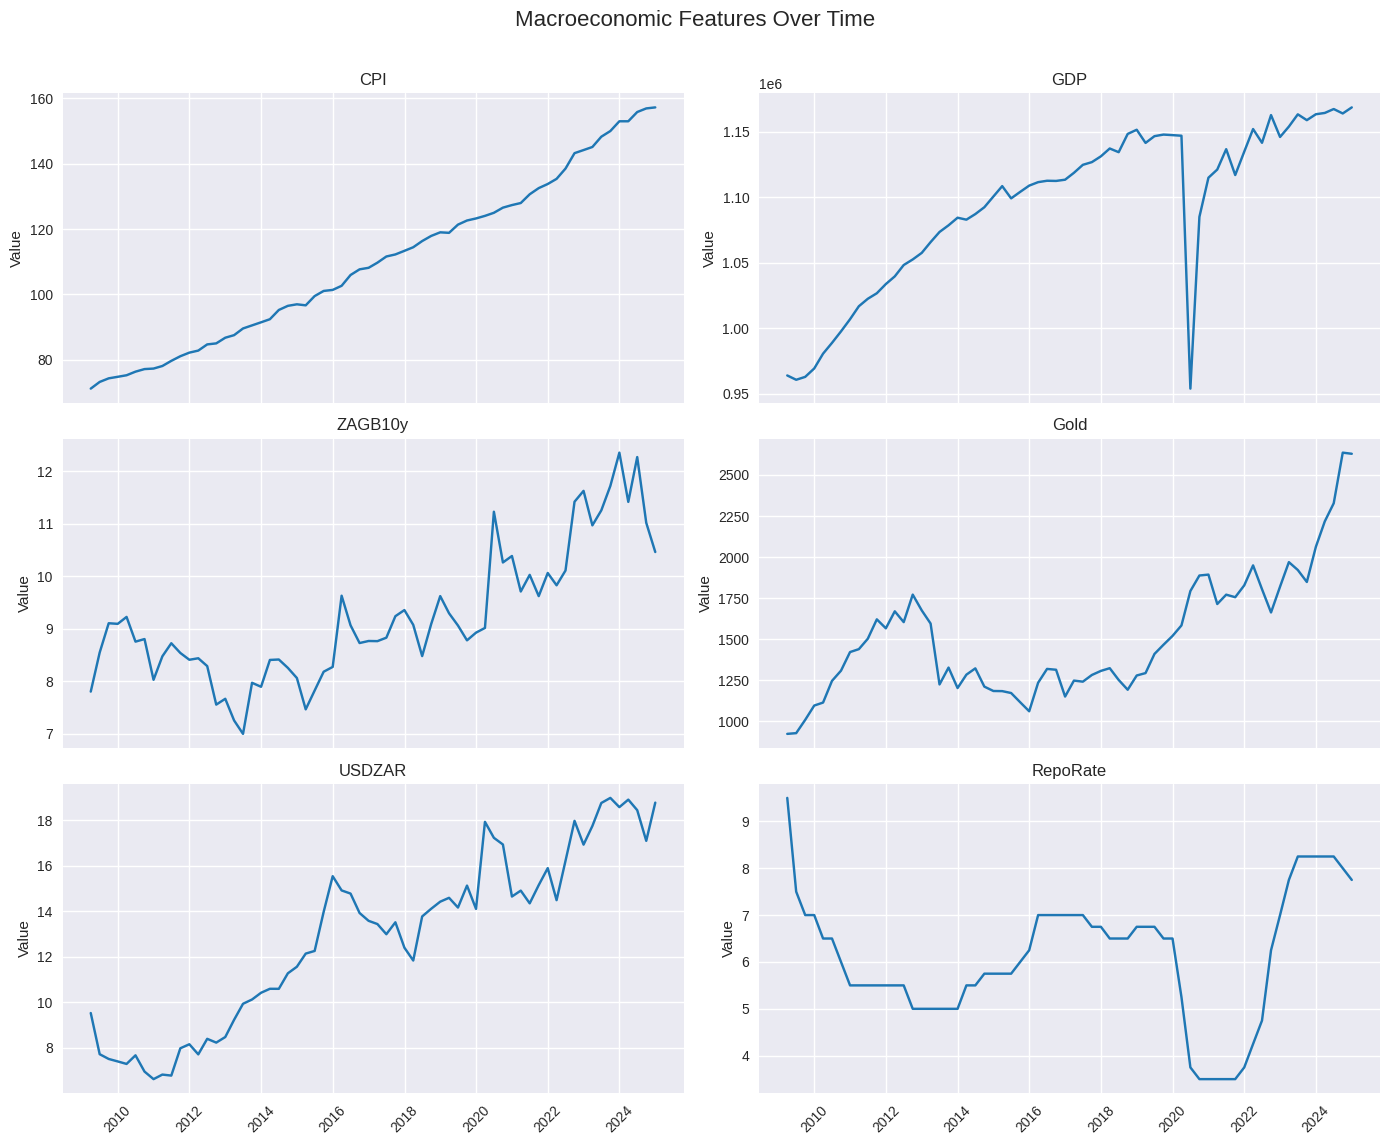

In [ ]:
import matplotlib.pyplot as plt

# Set style
plt.style.use("seaborn-v0_8")

# Number of features
num_features = macro_df.shape[1]
num_cols = 2
num_rows = (num_features + 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 4 * num_rows), sharex=True)
axes = axes.flatten()

for i, col in enumerate(macro_df.columns):
    axes[i].plot(macro_df.index, macro_df[col], color="tab:blue")
    axes[i].set_title(col, fontsize=12)
    axes[i].set_ylabel("Value")
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].grid(True)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Macroeconomic Features Over Time", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


## **Descriptive statistics and correlation**

In [ ]:
descriptive_stats = combined_clean.describe().T
descriptive_stats['skew'] = combined_clean.skew()
descriptive_stats['kurtosis'] = combined_clean.kurtosis()

descriptive_stats = descriptive_stats.round(2)

print("Descriptive statistics for combined macro features and sector returns:")
display(descriptive_stats)

Descriptive statistics for combined macro features and sector returns:


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
CPI,64.0,109.89,25.44,71.22,87.37,108.95,127.50,157.21,0.25,-1.06
GDP,64.0,1094366.08,62121.15,953846.20,1056298.50,1112573.95,1146248.02,1168684.40,-0.87,-0.33
ZAGB10y,64.0,9.22,1.26,7.00,8.41,8.97,9.88,12.36,0.75,-0.03
Gold,64.0,1510.28,377.54,922.60,1239.07,1415.40,1770.88,2636.10,0.97,0.92
USDZAR,64.0,12.85,3.80,6.62,9.45,13.67,15.24,18.97,-0.11,-1.17
RepoRate,64.0,6.10,1.37,3.50,5.44,6.25,7.00,9.50,-0.11,-0.20
Top40,64.0,0.02,0.07,-0.22,-0.02,0.03,0.07,0.21,-0.37,1.06
Dividend,64.0,0.01,0.09,-0.39,-0.03,0.01,0.07,0.21,-1.08,4.80
Financials,64.0,0.02,0.10,-0.52,-0.02,0.02,0.09,0.21,-2.21,10.76
Industrials,64.0,0.03,0.07,-0.13,-0.02,0.03,0.08,0.17,-0.16,-0.71


Correlation matrix for combined macro features and sector returns:


,CPI,GDP,ZAGB10y,Gold,USDZAR,RepoRate,Top40,Dividend,Financials,Industrials,Resources
CPI,1.000000,0.828375,0.822340,0.732037,0.941854,0.152187,-0.084906,-0.129817,-0.054819,-0.164922,-0.019250
GDP,0.828375,1.000000,0.461838,0.456748,0.799274,0.145115,-0.249725,-0.281511,-0.144338,-0.289443,-0.185783
ZAGB10y,0.822340,0.461838,1.000000,0.687061,0.748951,0.265662,0.075408,0.091296,0.103890,-0.029867,0.142601
Gold,0.732037,0.456748,0.687061,1.000000,0.564948,-0.024831,0.048638,0.006207,0.086612,0.044086,0.003893
USDZAR,0.941854,0.799274,0.748951,0.564948,1.000000,0.190293,-0.157332,-0.231542,-0.199432,-0.218749,-0.069885
RepoRate,0.152187,0.145115,0.265662,-0.024831,0.190293,1.000000,-0.155525,-0.199509,-0.085399,-0.135977,-0.120460
Top40,-0.084906,-0.249725,0.075408,0.048638,-0.157332,-0.155525,1.000000,0.740167,0.713017,0.808191,0.771450
Dividend,-0.129817,-0.281511,0.091296,0.006207,-0.231542,-0.199509,0.740167,1.000000,0.834690,0.455414,0.691162
Financials,-0.054819,-0.144338,0.103890,0.086612,-0.199432,-0.085399,0.713017,0.834690,1.000000,0.449387,0.486031
Industrials,-0.164922,-0.289443,-0.029867,0.044086,-0.218749,-0.135977,0.808191,0.455414,0.449387,1.000000,0.361665


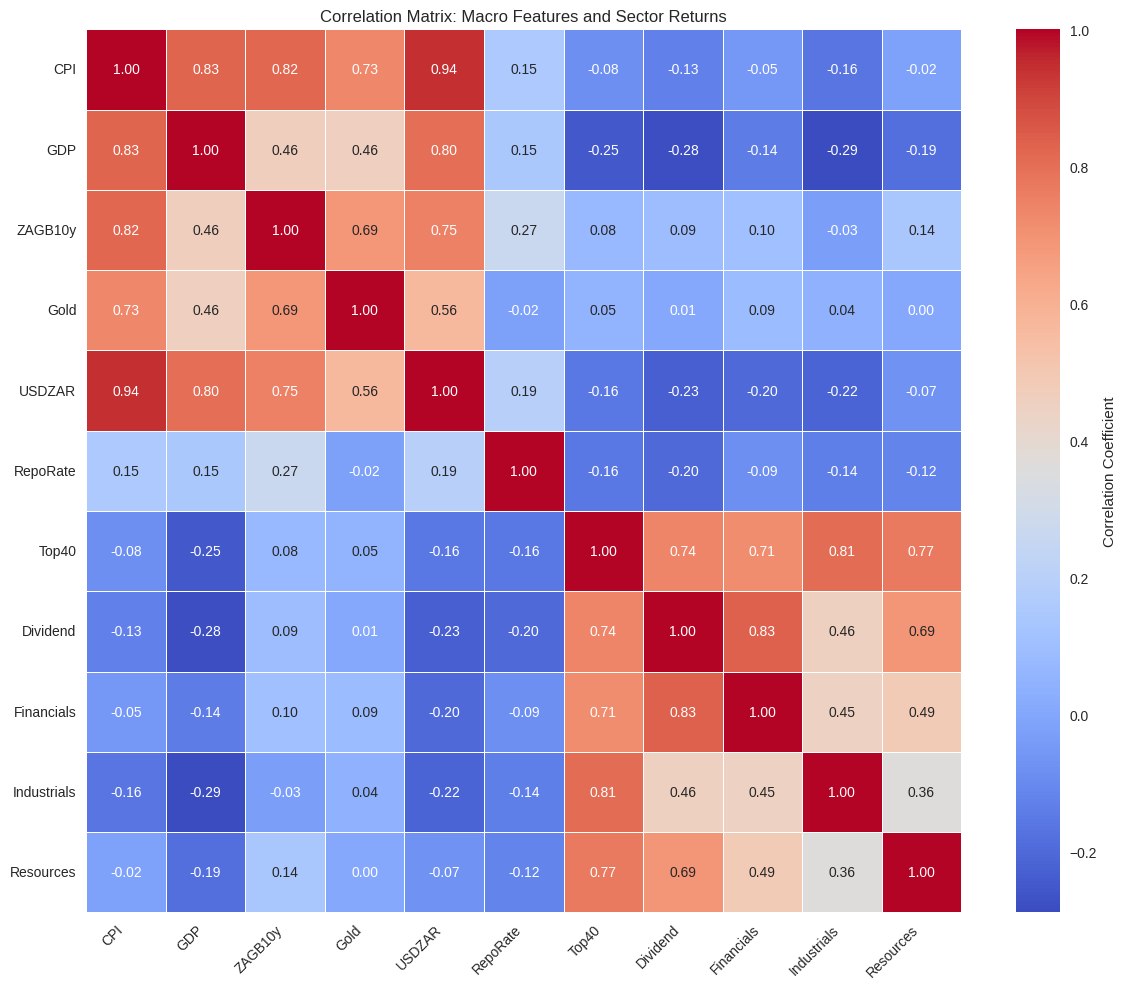

In [ ]:

corr_matrix = combined_clean.corr()

print("Correlation matrix for combined macro features and sector returns:")
display(corr_matrix)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title("Correlation Matrix: Macro Features and Sector Returns")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## **Winsorisation + Robust Scaling of macro features (X)**

In [ ]:
def winsorise_series(s, lower=0.01, upper=0.99):
    """
    Winsorise a Series by clipping to given quantiles.
    Helps reduce extreme macro shocks.
    """
    lower_q = s.quantile(lower)
    upper_q = s.quantile(upper)
    return s.clip(lower_q, upper_q)

X_winsor = X.apply(winsorise_series, axis=0)

print("Winsorised X head:")
display(X_winsor.head())

scaler = RobustScaler()
X_scaled_values = scaler.fit_transform(X_winsor)

X_scaled = pd.DataFrame(
    X_scaled_values,
    index=X_winsor.index,
    columns=X_winsor.columns
)

print("\nScaled X head:")
display(X_scaled.head())

X_prepared = X_scaled.copy()

print("\nFinal prepared macro feature matrix shape:", X_prepared.shape)


Winsorised X head:


,CPI,GDP,ZAGB10y,Gold,USDZAR,RepoRate
Date,,,,,,
2009-03-31,72.504653,963904.9,7.803000,925.434976,9.5250,8.7125
2009-06-30,73.260840,960596.7,8.547778,927.099976,7.7174,7.5000
2009-09-30,74.361330,962824.4,9.106522,1008.000000,7.5079,7.0000
2009-12-31,74.832960,969246.1,9.095000,1095.199951,7.3996,7.0000
2010-03-31,75.304600,980554.6,9.227000,1113.300049,7.2896,6.5000



Scaled X head:


,CPI,GDP,ZAGB10y,Gold,USDZAR,RepoRate
Date,,,,,,
2009-03-31,-0.908167,-1.652805,-0.795021,-0.921333,-0.715951,1.576
2009-06-30,-0.889323,-1.689584,-0.288553,-0.918202,-1.028118,0.800
2009-09-30,-0.861899,-1.664818,0.091407,-0.766077,-1.064298,0.480
2009-12-31,-0.850146,-1.593425,0.083572,-0.602106,-1.083001,0.480
2010-03-31,-0.838393,-1.467705,0.173335,-0.568070,-1.101998,0.160



Final prepared macro feature matrix shape: (64, 6)


##**Box plots for X before and after Winsorisation/Scaling**

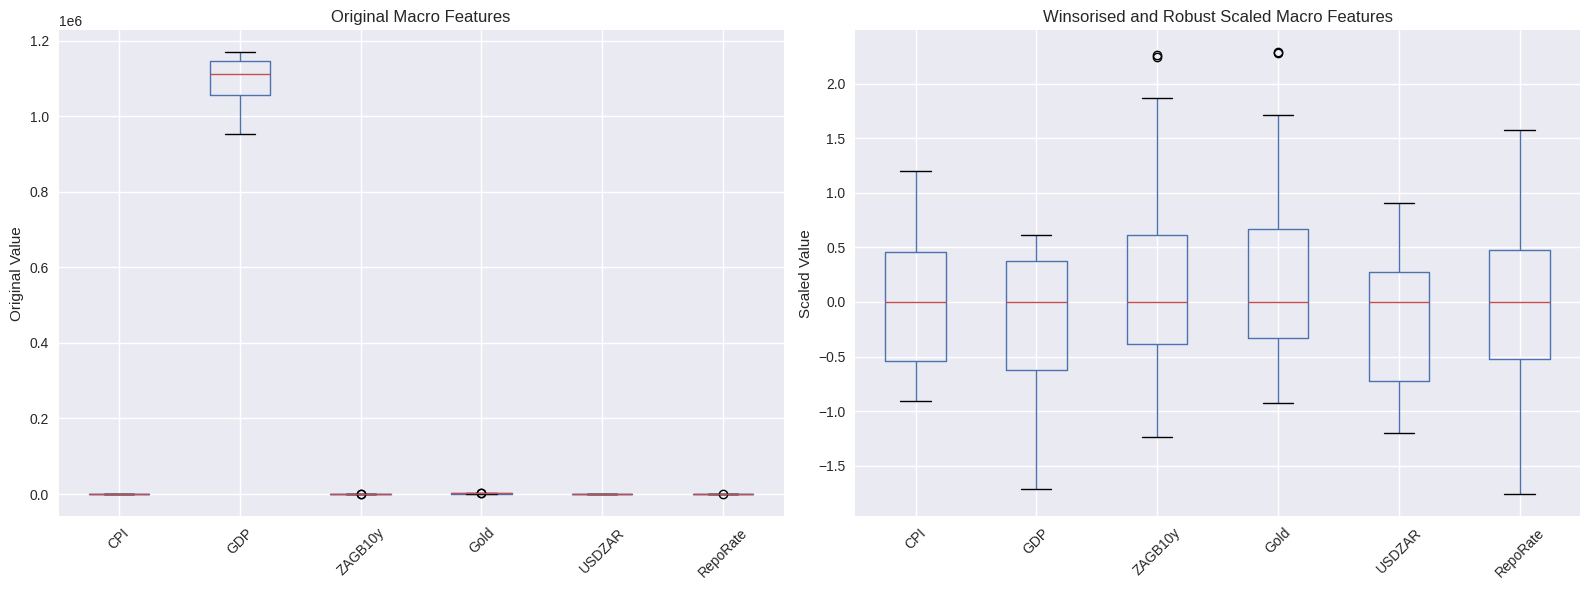

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
X.boxplot(ax=axes[0])
axes[0].set_title('Original Macro Features')
axes[0].set_ylabel('Original Value')
axes[0].tick_params(axis='x', rotation=45)

# Box plot for Winsorised and Robust Scaled macro features
X_prepared.boxplot(ax=axes[1])
axes[1].set_title('Winsorised and Robust Scaled Macro Features')
axes[1].set_ylabel('Scaled Value')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# **Modelling**

## **Define rolling train/test windows for walk-forward backtest**

In [ ]:

index_q = final_quarterly_index

print("Total number of quarterly observations:", len(index_q))
print("First 5 dates:", index_q[:5].tolist())
print("Last 5 dates:", index_q[-5:].tolist())

# Configuration for walk-forward
TRAIN_WINDOW_QTRS = 12   # 12 quarters = 3 years training
TEST_HORIZON_QTRS = 1    # 1 quarter test each step

def generate_rolling_windows(index, train_window, test_horizon):
    """
    Given a DatetimeIndex of quarterly dates, generate a list of (train_idx, test_idx)
    where:
      - train_idx: slice of dates used for training
      - test_idx:  slice of dates used for testing (next period(s))
    """
    windows = []
    n = len(index)

    start_train = 0
    while True:
        end_train = start_train + train_window
        end_test = end_train + test_horizon

        if end_test > n:
            break

        train_idx = index[start_train:end_train]
        test_idx  = index[end_train:end_test]

        windows.append((train_idx, test_idx))


        start_train += test_horizon

    return windows

rolling_windows = generate_rolling_windows(
    index=index_q,
    train_window=TRAIN_WINDOW_QTRS,
    test_horizon=TEST_HORIZON_QTRS
)

print("\nNumber of rolling windows:", len(rolling_windows))


for i, (train_idx, test_idx) in enumerate(rolling_windows[:3], start=1):
    print(f"\nWindow {i}:")
    print("  Train:", train_idx[0].date(), "→", train_idx[-1].date(), f"({len(train_idx)} quarters)")
    print("  Test: ", test_idx[0].date(), "→", test_idx[-1].date(),  f"({len(test_idx)} quarter)")


Total number of quarterly observations: 64
First 5 dates: [Timestamp('2009-03-31 00:00:00'), Timestamp('2009-06-30 00:00:00'), Timestamp('2009-09-30 00:00:00'), Timestamp('2009-12-31 00:00:00'), Timestamp('2010-03-31 00:00:00')]
Last 5 dates: [Timestamp('2023-12-31 00:00:00'), Timestamp('2024-03-31 00:00:00'), Timestamp('2024-06-30 00:00:00'), Timestamp('2024-09-30 00:00:00'), Timestamp('2024-12-31 00:00:00')]

Number of rolling windows: 52

Window 1:
  Train: 2009-03-31 → 2011-12-31 (12 quarters)
  Test:  2012-03-31 → 2012-03-31 (1 quarter)

Window 2:
  Train: 2009-06-30 → 2012-03-31 (12 quarters)
  Test:  2012-06-30 → 2012-06-30 (1 quarter)

Window 3:
  Train: 2009-09-30 → 2012-06-30 (12 quarters)
  Test:  2012-09-30 → 2012-09-30 (1 quarter)


## **Hierarchical Risk Parity (HRP) implementation**

In [ ]:

try:
    from scipy.cluster.hierarchy import linkage
    from scipy.spatial.distance import squareform
except ModuleNotFoundError:
    print("scipy not found, installing...")
    !pip install scipy --quiet
    from scipy.cluster.hierarchy import linkage
    from scipy.spatial.distance import squareform


def correl_to_distance(corr):
    """
    Convert correlation matrix to a distance matrix for clustering.
    Distance_ij = sqrt(0.5 * (1 - corr_ij))
    """
    return np.sqrt(0.5 * (1 - corr))


def _seriation(Z, N):
    """
    Recursively extract the order of items from a hierarchical clustering linkage matrix.

    Z: linkage matrix
    N: number of original items
    """
    order = []

    def _recurse(node_id):
        if node_id < N:
            order.append(node_id)
        else:
            left = int(Z[node_id - N, 0])
            right = int(Z[node_id - N, 1])
            _recurse(left)
            _recurse(right)

    _recurse(len(Z) + N - 2)
    return order


def quasi_diagonalize(cov):
    """
    Reorder the covariance matrix according to the hierarchical clustering structure.
    Returns:
      cov_sorted: reordered covariance matrix
      ordered_index: index labels in the new order
    """

    corr = cov.corr()
    dist = correl_to_distance(corr)


    dist_condensed = squareform(dist.values, checks=False)
    Z = linkage(dist_condensed, method="single")


    order = _seriation(Z, N=cov.shape[0])

    ordered_index = cov.index[order]
    cov_sorted = cov.loc[ordered_index, ordered_index]
    return cov_sorted, ordered_index


def get_cluster_variance(cov, cluster_items):
    """
    Compute cluster variance w' Σ w using inverse-variance weights within the cluster.
    """
    cov_slice = cov.loc[cluster_items, cluster_items]
    inv_diag = 1.0 / np.diag(cov_slice.values)
    weights = inv_diag / inv_diag.sum()
    variance = float(weights.T @ cov_slice.values @ weights)
    return variance


def hrp_allocation(cov):
    """
    Compute Hierarchical Risk Parity weights given a covariance matrix (pd.DataFrame).
    Returns a pd.Series of weights indexed by asset names.
    """
    cov_sorted, ordered_index = quasi_diagonalize(cov)
    assets = list(cov_sorted.index)


    clusters = [assets]
    weights = pd.Series(1.0, index=assets)

    while clusters:
        cluster = clusters.pop()

        if len(cluster) == 1:

            continue


        split = len(cluster) // 2
        left_cluster = cluster[:split]
        right_cluster = cluster[split:]


        clusters.append(left_cluster)
        clusters.append(right_cluster)


        var_left = get_cluster_variance(cov_sorted, left_cluster)
        var_right = get_cluster_variance(cov_sorted, right_cluster)

        # Allocate risk between clusters via inverse-variance
        alpha = 1.0 - var_left / (var_left + var_right)

        # Scale weights within each subcluster
        weights[left_cluster] *= alpha
        weights[right_cluster] *= (1.0 - alpha)

    # Normalise weights to sum to 1, and reorder back to original covariance order
    weights = weights / weights.sum()
    weights = weights.reindex(cov.index)

    return weights


print("HRP functions defined. Example: hrp_allocation(cov_matrix) where cov_matrix is a covariance DataFrame.")


HRP functions defined. Example: hrp_allocation(cov_matrix) where cov_matrix is a covariance DataFrame.


## **Autoencoder-based covariance estimation**

In [ ]:


try:
    from tensorflow import keras
    from tensorflow.keras import layers
except ModuleNotFoundError:
    print("TensorFlow not found, installing...")
    !pip install tensorflow --quiet
    from tensorflow import keras
    from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler


def build_autoencoder(input_dim, latent_dim=3, hidden_units=16):
    """
    Build a simple symmetric autoencoder for sector returns.

    input_dim   : number of assets (sectors)
    latent_dim  : size of bottleneck layer (non-linear factors)
    hidden_units: units in hidden layers
    """
    inputs = keras.Input(shape=(input_dim,))

    # Encoder
    x = layers.Dense(hidden_units, activation="relu")(inputs)
    bottleneck = layers.Dense(latent_dim, activation="relu", name="bottleneck")(x)

    # Decoder
    x = layers.Dense(hidden_units, activation="relu")(bottleneck)
    outputs = layers.Dense(input_dim, activation="linear")(x)

    autoencoder = keras.Model(inputs=inputs, outputs=outputs, name="ae_cov")

    autoencoder.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse"
    )


    encoder = keras.Model(inputs=inputs, outputs=bottleneck, name="encoder")

    return autoencoder, encoder


def autoencoder_covariance(returns_df, latent_dim=3, hidden_units=16,
                           epochs=200, batch_size=16, verbose=0):
    """
    Estimate a denoised covariance matrix using an autoencoder.

    returns_df : DataFrame of shape (T, N) – sector returns for training window
    Returns:
      cov_ae_df      : covariance of reconstructed returns (N x N DataFrame)
      autoencoder    : trained autoencoder model
      encoder        : encoder model
      scaler_returns : fitted StandardScaler (for potential reuse)
    """
    # --- local reproducibility setup ---
    import os, random, numpy as np, tensorflow as tf
    os.environ["PYTHONHASHSEED"] = str(20251101)
    random.seed(20251101)
    np.random.seed(20251101)
    tf.random.set_seed(20251101)
    R = returns_df.copy()
    assets = list(R.columns)


    scaler = StandardScaler()
    R_scaled = scaler.fit_transform(R.values)


    input_dim = R_scaled.shape[1]
    autoencoder, encoder = build_autoencoder(
        input_dim=input_dim,
        latent_dim=latent_dim,
        hidden_units=hidden_units
    )

    history = autoencoder.fit(
        R_scaled, R_scaled,
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose,
        shuffle=False# to ensure training batches are always in same order
    )


    R_recon_scaled = autoencoder.predict(R_scaled, verbose=0)
    R_recon = scaler.inverse_transform(R_recon_scaled)


    cov_ae = np.cov(R_recon, rowvar=False)
    cov_ae_df = pd.DataFrame(cov_ae, index=assets, columns=assets)

    return cov_ae_df, autoencoder, encoder, scaler


print("Autoencoder covariance helpers defined.\n"
      "Example: cov_ae, ae_model, enc, scaler = autoencoder_covariance(Y_train)")


train_idx_test, _ = rolling_windows[0]
Y_train_test = Y.loc[train_idx_test]

print("\nRunning a quick autoencoder covariance test on the first 12 quarters...")
print("Y_train_test shape:", Y_train_test.shape)

cov_ae_test, ae_model_test, enc_test, scaler_test = autoencoder_covariance(
    Y_train_test,
    latent_dim=2,
    hidden_units=8,
    epochs=50,
    batch_size=8,
    verbose=0
)

print("\nAutoencoder-based covariance matrix (test) shape:", cov_ae_test.shape)
display(cov_ae_test)


Autoencoder covariance helpers defined.
Example: cov_ae, ae_model, enc, scaler = autoencoder_covariance(Y_train)

Running a quick autoencoder covariance test on the first 12 quarters...
Y_train_test shape: (12, 5)

Autoencoder-based covariance matrix (test) shape: (5, 5)


,Top40,Dividend,Financials,Industrials,Resources
Top40,0.000531,0.000524,0.000849,0.000217,0.000593
Dividend,0.000524,0.000516,0.000835,0.000211,0.000583
Financials,0.000849,0.000835,0.001552,0.000654,0.001109
Industrials,0.000217,0.000211,0.000654,0.000575,0.000498
Resources,0.000593,0.000583,0.001109,0.000498,0.000796


## **Covariance estimators (Sample, Ledoit–Wolf, Autoencoder) + HRP weights test**

In [ ]:
def get_covariance_matrices(Y_train_window,
                            use_autoencoder=True,
                            ae_latent_dim=2,
                            ae_hidden_units=8,
                            ae_epochs=50):
    """
    Given a training window of sector returns (DataFrame),
    compute different covariance estimates.

    Returns a dict with keys:
      'sample', 'ledoit', 'autoencoder' (optional)
    """
    covs = {}


    cov_sample = Y_train_window.cov()
    covs["sample"] = cov_sample


    lw = LedoitWolf().fit(Y_train_window.values)
    cov_lw = pd.DataFrame(lw.covariance_,
                          index=Y_train_window.columns,
                          columns=Y_train_window.columns)
    covs["ledoit"] = cov_lw


    if use_autoencoder:
        cov_ae, ae_model, enc, scaler = autoencoder_covariance(
            Y_train_window,
            latent_dim=ae_latent_dim,
            hidden_units=ae_hidden_units,
            epochs=ae_epochs,
            batch_size=8,
            verbose=0
        )
        covs["autoencoder"] = cov_ae

    return covs


train_idx_test, _ = rolling_windows[0]
Y_train_test = Y.loc[train_idx_test]

print("Testing covariance estimators on first training window:")
print("Y_train_test shape:", Y_train_test.shape)

cov_dict_test = get_covariance_matrices(
    Y_train_test,
    use_autoencoder=True,
    ae_latent_dim=2,
    ae_hidden_units=8,
    ae_epochs=50
)


for name, cov_mat in cov_dict_test.items():
    print(f"\n{name.upper()} covariance matrix:")
    display(cov_mat)


    w_hrp = hrp_allocation(cov_mat)
    print(f"HRP weights using {name} covariance:")
    display(w_hrp)


Testing covariance estimators on first training window:
Y_train_test shape: (12, 5)

SAMPLE covariance matrix:


,Top40,Dividend,Financials,Industrials,Resources
Top40,0.006440,0.004831,0.005792,0.005931,0.006917
Dividend,0.004831,0.005747,0.005547,0.005589,0.004212
Financials,0.005792,0.005547,0.007187,0.006302,0.004924
Industrials,0.005931,0.005589,0.006302,0.006680,0.005307
Resources,0.006917,0.004212,0.004924,0.005307,0.008879


HRP weights using sample covariance:


,0
Top40,NaN
Dividend,0.534895
Financials,0.224051
Industrials,0.241054
Resources,NaN



LEDOIT covariance matrix:


,Top40,Dividend,Financials,Industrials,Resources
Top40,0.005965,0.003887,0.004661,0.004773,0.005566
Dividend,0.003887,0.005407,0.004463,0.004497,0.003389
Financials,0.004661,0.004463,0.006565,0.005071,0.003963
Industrials,0.004773,0.004497,0.005071,0.006157,0.004270
Resources,0.005566,0.003389,0.003963,0.004270,0.007927


HRP weights using ledoit covariance:


,0
Top40,NaN
Dividend,0.513671
Financials,0.235368
Industrials,0.250960
Resources,NaN



AUTOENCODER covariance matrix:


,Top40,Dividend,Financials,Industrials,Resources
Top40,0.000531,0.000524,0.000849,0.000217,0.000593
Dividend,0.000524,0.000516,0.000835,0.000211,0.000583
Financials,0.000849,0.000835,0.001552,0.000654,0.001109
Industrials,0.000217,0.000211,0.000654,0.000575,0.000498
Resources,0.000593,0.000583,0.001109,0.000498,0.000796


HRP weights using autoencoder covariance:


,0
Top40,0.326047
Dividend,0.335525
Financials,0.114772
Industrials,NaN
Resources,0.223655


## **Create sector winner labels for DNN sector rotation**

In [ ]:
def create_winner_labels(Y_returns, method="median"):
    """
    Create binary labels indicating which sectors 'outperformed' each quarter.

    Parameters
    ----------
    Y_returns : DataFrame
        Quarterly sector returns (index = quarters, columns = sectors).
    method : str
        'median'  -> label sectors above cross-sectional median as winners
        'mean'    -> label sectors above cross-sectional mean as winners

    Returns
    -------
    labels : DataFrame
        Same shape as Y_returns, with 1 for winners, 0 for non-winners.
    """
    Y = Y_returns.copy()

    if method == "median":
        cross_section = Y.median(axis=1)
    elif method == "mean":
        cross_section = Y.mean(axis=1)
    else:
        raise ValueError("method must be 'median' or 'mean'")


    bench = pd.DataFrame(
        np.repeat(cross_section.values.reshape(-1, 1), Y.shape[1], axis=1),
        index=Y.index,
        columns=Y.columns
    )

    labels = (Y > bench).astype(int)
    return labels


labels_winners = create_winner_labels(Y, method="median")

print("Winner label matrix shape:", labels_winners.shape)
display(labels_winners.head())


winners_per_quarter = labels_winners.sum(axis=1)
print("\nNumber of winners per quarter (first 10 rows):")
display(winners_per_quarter.head(10))

print("\nValue counts of winners per quarter:")
print(winners_per_quarter.value_counts().sort_index())


Winner label matrix shape: (64, 5)


,Top40,Dividend,Financials,Industrials,Resources
Date,,,,,
2009-03-31,1,0,0,0,1
2009-06-30,0,1,0,1,0
2009-09-30,0,1,0,1,0
2009-12-31,1,0,0,0,1
2010-03-31,0,1,1,0,0



Number of winners per quarter (first 10 rows):


,0
Date,
2009-03-31,2
2009-06-30,2
2009-09-30,2
2009-12-31,2
2010-03-31,2
2010-06-30,2
2010-09-30,2
2010-12-31,2
2011-03-31,2



Value counts of winners per quarter:
2    64
Name: count, dtype: int64


## **Build & train a DNN classifier (test on first rolling window)**

In [ ]:
def build_dnn_classifier(input_dim, output_dim, hidden_units=32, dropout_rate=0.1):
    """
    Simple feedforward DNN for multi-label classification (1-vs-rest per sector).
    Predicts probability that each sector will outperform next quarter.
    """
    os.environ["PYTHONHASHSEED"] = str(20251101)
    random.seed(20251101)
    np.random.seed(20251101)
    tf.random.set_seed(20251101)
    model = Sequential([
        Dense(hidden_units, activation='relu', input_shape=(input_dim,)),
        Dropout(dropout_rate),
        Dense(hidden_units, activation='relu'),
        Dense(output_dim, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model



train_idx_test, test_idx_test = rolling_windows[0]

X_train_test = X_prepared.loc[train_idx_test]
Y_train_test_labels = labels_winners.loc[train_idx_test]

X_test_test = X_prepared.loc[test_idx_test]
Y_test_test_labels = labels_winners.loc[test_idx_test]

print("Train X shape:", X_train_test.shape)
print("Train Y labels shape:", Y_train_test_labels.shape)
print("Test X shape:", X_test_test.shape)
print("Test Y labels shape:", Y_test_test_labels.shape)


input_dim = X_train_test.shape[1]   # 6 macro variables
output_dim = Y_train_test_labels.shape[1]  # 4 sectors
dnn_model = build_dnn_classifier(input_dim, output_dim)


es = EarlyStopping(patience=20, restore_best_weights=True)

history = dnn_model.fit(
    X_train_test,
    Y_train_test_labels,
    validation_split=0.2,
    epochs=300,
    batch_size=4,
    verbose=0,
    shuffle=False,
    callbacks=[es]
)

print("\nTraining complete. DNN ready.")

# Predict next-quarter sector winners
pred_probs = dnn_model.predict(X_test_test, verbose=0)
pred_labels = (pred_probs > 0.5).astype(int)

print("\nPredicted winner probabilities for next quarter:")
display(pd.DataFrame(pred_probs, index=test_idx_test, columns=Y_train_test_labels.columns))

print("\nPredicted winner labels:")
display(pd.DataFrame(pred_labels, index=test_idx_test, columns=Y_train_test_labels.columns))

print("\nTrue next-quarter winner labels:")
display(Y_test_test_labels)


Train X shape: (12, 6)
Train Y labels shape: (12, 5)
Test X shape: (1, 6)
Test Y labels shape: (1, 5)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training complete. DNN ready.

Predicted winner probabilities for next quarter:


,Top40,Dividend,Financials,Industrials,Resources
Date,,,,,
2012-03-31,0.380911,0.427993,0.43499,0.557561,0.431367



Predicted winner labels:


,Top40,Dividend,Financials,Industrials,Resources
Date,,,,,
2012-03-31,0,0,0,1,0



True next-quarter winner labels:


,Top40,Dividend,Financials,Industrials,Resources
Date,,,,,
2012-03-31,0,1,1,0,0


## **Overlay DNN sector signals on top of HRP weights**

In [ ]:
def apply_dnn_overlay(base_weights, pred_probs_row, sectors, threshold=0.5):
    """
    Combine base HRP weights with DNN sector signals.

    base_weights   : pd.Series of HRP weights (index = sector names)
    pred_probs_row : 1D array of predicted winner probabilities for each sector
    sectors        : list of sector names in the same order as pred_probs_row
    threshold      : probability cut-off to classify as 'winner'

    Logic:
      - Identify sectors where prob >= threshold (winners).
      - If at least one winner:
          * Set loser weights to 0
          * Re-normalise weights across winners only.
        Else:
          * Keep base_weights unchanged.
    """
    os.environ["PYTHONHASHSEED"] = str(20251101)
    random.seed(20251101)
    np.random.seed(20251101)
    tf.random.set_seed(20251101)
    w = base_weights.copy().astype(float)
    probs = pd.Series(pred_probs_row, index=sectors)


    winners_mask = probs >= threshold
    winners = probs.index[winners_mask]

    print("Predicted winner sectors (prob >= {:.2f}):".format(threshold), list(winners))

    if winners_mask.sum() == 0:
        print("No winners above threshold. Returning base HRP weights.")
        return w


    w.loc[~winners_mask] = 0.0


    if w.sum() > 0:
        w = w / w.sum()
    else:

        print("Warning: zero total weight after tilting. Using base weights.")
        w = base_weights.copy()

    return w



train_idx_test, test_idx_test = rolling_windows[0]
Y_train_test = Y.loc[train_idx_test]


cov_ae_window, _, _, _ = autoencoder_covariance(
    Y_train_test,
    latent_dim=2,
    hidden_units=8,
    epochs=50,
    batch_size=8,
    verbose=0
)
w_hrp_ae = hrp_allocation(cov_ae_window)

print("Base HRP weights using AE covariance:")
display(w_hrp_ae)


pred_probs_first = pred_probs[0]
sectors = list(Y.columns)

print("\nDNN predicted probabilities for next quarter:")
display(pd.Series(pred_probs_first, index=sectors))


w_hrp_dnn = apply_dnn_overlay(
    base_weights=w_hrp_ae,
    pred_probs_row=pred_probs_first,
    sectors=sectors,
    threshold=0.5
)

print("\nFinal HRP+DNN portfolio weights for next quarter:")
display(w_hrp_dnn)


Base HRP weights using AE covariance:


,0
Top40,0.326047
Dividend,0.335525
Financials,0.114772
Industrials,NaN
Resources,0.223655



DNN predicted probabilities for next quarter:


,0
Top40,0.380911
Dividend,0.427993
Financials,0.434990
Industrials,0.557561
Resources,0.431367


Predicted winner sectors (prob >= 0.50): ['Industrials']

Final HRP+DNN portfolio weights for next quarter:


,0
Top40,0.326047
Dividend,0.335525
Financials,0.114772
Industrials,NaN
Resources,0.223655


## **Walk-forward backtest: HRP_AE vs HRP_AE_DNN**

In [ ]:
def sanitize_covariance(cov):
    """
    Clean covariance matrix:
      - ensure float
      - replace inf with NaN
      - enforce positive diagonal
      - fill remaining NaNs with 0
    """
    cov = cov.astype(float).copy()
    cov.values[~np.isfinite(cov.values)] = np.nan


    for i, a in enumerate(cov.index):
        v = cov.iloc[i, i]
        if (not np.isfinite(v)) or (v <= 0):
            cov.iloc[i, i] = 1e-8


    cov = cov.fillna(0.0)
    return cov



def correl_to_distance(corr):
    """
    Safe conversion of correlation to distance.
    Cleans NaNs/inf and clips correlations.
    """
    corr = corr.astype(float).copy()
    corr.values[~np.isfinite(corr.values)] = np.nan
    corr = corr.fillna(0.0)


    corr_vals = np.clip(corr.values, -0.9999, 0.9999)
    corr = pd.DataFrame(corr_vals, index=corr.index, columns=corr.columns)

    return np.sqrt(0.5 * (1 - corr))


def hrp_allocation_safe(cov):
    """
    Wrapper around hrp_allocation that sanitises the covariance first.
    """
    cov_clean = sanitize_covariance(cov)
    return hrp_allocation(cov_clean)


def clean_weights(w, sectors):
    """
    Ensure weights are numeric, non-NaN and sum to 1 over the given sector list.
    If the sum is <= 0 after cleaning, fall back to equal-weight.
    """
    w = w.reindex(sectors).astype(float)
    w = w.fillna(0.0)
    total = w.sum()
    if total <= 0:
        w = pd.Series(1.0 / len(sectors), index=sectors)
    else:
        w = w / total
    return w



def backtest_hrp_ae_dnn(X_prepared, Y, labels_winners, rolling_windows,
                        ae_latent_dim=2, ae_hidden_units=8,
                        ae_epochs=50, dnn_hidden_units=32,
                        dnn_dropout=0.1, dnn_epochs=300,
                        dnn_batch_size=4, threshold=0.5):
    """
    Walk-forward backtest for:
      - HRP_AE      : HRP portfolio using AE covariance only
      - HRP_AE_DNN  : HRP + DNN overlay
    """
    sectors = list(Y.columns)
    results = []

    for win_id, (train_idx, test_idx) in enumerate(rolling_windows, start=1):
        X_train = X_prepared.loc[train_idx]
        X_test  = X_prepared.loc[test_idx]

        Y_train = Y.loc[train_idx]
        Y_test  = Y.loc[test_idx]
        Y_labels_train = labels_winners.loc[train_idx]


        if X_test.empty or Y_test.empty:
            continue


        cov_ae_window, _, _, _ = autoencoder_covariance(
            Y_train,
            latent_dim=ae_latent_dim,
            hidden_units=ae_hidden_units,
            epochs=ae_epochs,
            batch_size=8,
            verbose=0
        )
        w_hrp_ae = hrp_allocation_safe(cov_ae_window)
        w_hrp_ae = clean_weights(w_hrp_ae, sectors)


        input_dim = X_train.shape[1]
        output_dim = Y_labels_train.shape[1]

        dnn_model = build_dnn_classifier(
            input_dim=input_dim,
            output_dim=output_dim,
            hidden_units=dnn_hidden_units,
            dropout_rate=dnn_dropout
        )

        es = EarlyStopping(patience=20, restore_best_weights=True)

        dnn_model.fit(
            X_train,
            Y_labels_train,
            validation_split=0.2,
            epochs=dnn_epochs,
            batch_size=dnn_batch_size,
            verbose=0,
            callbacks=[es]
        )


        probs_test = dnn_model.predict(X_test, verbose=0)
        probs_row  = probs_test[0]


        w_hrp_ae_dnn = apply_dnn_overlay(
            base_weights=w_hrp_ae,
            pred_probs_row=probs_row,
            sectors=sectors,
            threshold=threshold
        )
        w_hrp_ae_dnn = clean_weights(w_hrp_ae_dnn, sectors)


        r_test = Y_test.iloc[0]

        ret_hrp_ae     = float(np.dot(w_hrp_ae.values,     r_test.values))
        ret_hrp_ae_dnn = float(np.dot(w_hrp_ae_dnn.values, r_test.values))

        results.append({
            "Date": test_idx[0],
            "HRP_AE": ret_hrp_ae,
            "HRP_AE_DNN": ret_hrp_ae_dnn
        })

    returns_df = pd.DataFrame(results).set_index("Date").sort_index()
    return returns_df




returns_hrp_dnn = backtest_hrp_ae_dnn(
    X_prepared=X_prepared,
    Y=Y,
    labels_winners=labels_winners,
    rolling_windows=rolling_windows,
    ae_latent_dim=2,
    ae_hidden_units=8,
    ae_epochs=50,
    dnn_hidden_units=32,
    dnn_dropout=0.1,
    dnn_epochs=200,
    dnn_batch_size=4,
    threshold=0.5
)

print("Backtest returns shape:", returns_hrp_dnn.shape)
display(returns_hrp_dnn.head())
display(returns_hrp_dnn.tail())


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Top40', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Resources']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Dividend', 'Financials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Resources']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Resources']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Backtest returns shape: (52, 2)


,HRP_AE,HRP_AE_DNN
Date,,
2012-03-31,0.055984,0.055984
2012-06-30,-0.026330,-0.026330
2012-09-30,0.042674,0.036390
2012-12-31,0.087416,0.087416
2013-03-31,-0.009834,-0.009834


,HRP_AE,HRP_AE_DNN
Date,,
2023-12-31,0.044985,0.035079
2024-03-31,-0.049050,-0.114349
2024-06-30,0.078684,0.067646
2024-09-30,0.043925,0.090742
2024-12-31,-0.072068,-0.035714


## **Cumulative returns and performance summary for HRP_AE vs HRP_AE_DNN**

Backtest returns shape: (52, 2)


,HRP_AE,HRP_AE_DNN
Date,,
2012-03-31,0.055984,0.055984
2012-06-30,-0.026330,-0.026330
2012-09-30,0.042674,0.036390
2012-12-31,0.087416,0.087416
2013-03-31,-0.009834,-0.009834



Cumulative returns (head):


,HRP_AE_Cumulative,HRP_AE_DNN_Cumulative
Date,,
2012-03-31,0.055984,0.055984
2012-06-30,0.028180,0.028180
2012-09-30,0.072056,0.065595
2012-12-31,0.165771,0.158745
2013-03-31,0.154307,0.147351



Performance summary (annualised, quarterly data):


,Ann.Return,Ann.Vol,Sharpe
HRP_AE,0.036123,0.168055,0.214945
HRP_AE_DNN,0.018700,0.173405,0.107839


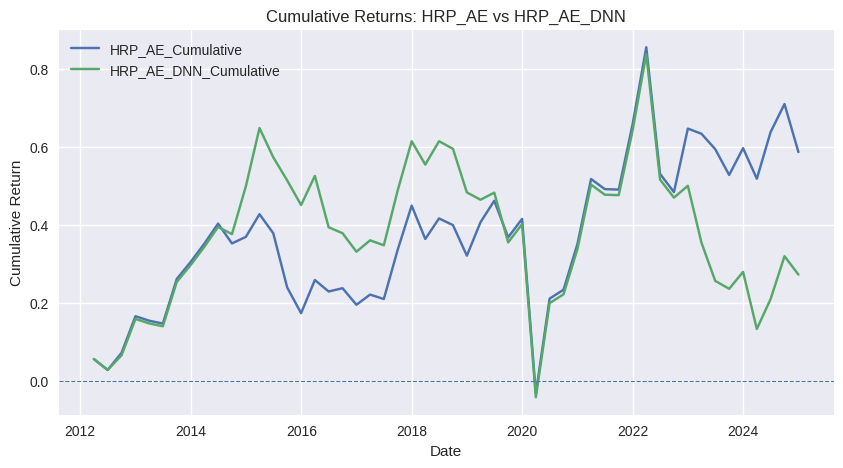

In [ ]:
print("Backtest returns shape:", returns_hrp_dnn.shape)
display(returns_hrp_dnn.head())


cum_returns = (1 + returns_hrp_dnn).cumprod() - 1
cum_returns.columns = [c + "_Cumulative" for c in cum_returns.columns]

print("\nCumulative returns (head):")
display(cum_returns.head())


def performance_stats(returns, periods_per_year=4, name="Strategy"):
    """
    Compute simple performance statistics for a return series.
    returns: pd.Series of quarterly returns.
    """
    n = len(returns)
    if n == 0:
        return pd.Series(
            {"Ann.Return": np.nan, "Ann.Vol": np.nan, "Sharpe": np.nan},
            name=name
        )


    total_return = (1 + returns).prod() - 1
    ann_return = (1 + total_return) ** (periods_per_year / n) - 1

    ann_vol = returns.std(ddof=1) * np.sqrt(periods_per_year)


    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    return pd.Series(
        {"Ann.Return": ann_return, "Ann.Vol": ann_vol, "Sharpe": sharpe},
        name=name
    )

stats_list = []
for col in returns_hrp_dnn.columns:
    stats_list.append(performance_stats(returns_hrp_dnn[col], name=col))

perf_table = pd.DataFrame(stats_list)

print("\nPerformance summary (annualised, quarterly data):")
display(perf_table)


plt.figure(figsize=(10, 5))
for col in cum_returns.columns:
    plt.plot(cum_returns.index, cum_returns[col], label=col)

plt.axhline(0, linestyle="--", linewidth=0.8)
plt.title("Cumulative Returns: HRP_AE vs HRP_AE_DNN")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()


## **Full strategy benchmark: returns + weights for all models**

In [ ]:
def markowitz_weights(mu, cov, sectors):
    """
    Simple Markowitz portfolio:
      w ∝ Σ^{-1} μ
      - cov is sanitised
      - negative weights clipped to 0 (approx long-only)
      - renormalised to sum to 1
    """
    cov_clean = sanitize_covariance(cov)
    mu = mu.reindex(sectors).astype(float)

    inv_cov = np.linalg.pinv(cov_clean.values)
    raw_w = inv_cov @ mu.values

    w = pd.Series(raw_w, index=sectors)
    w = w.clip(lower=0.0)
    if w.sum() <= 0:
        w = pd.Series(1.0 / len(sectors), index=sectors)
    else:
        w = w / w.sum()
    return w



def dnn_only_weights(pred_probs_row, sectors, threshold=0.5):
    """
    DNN-only strategy:
      - identify sectors with prob >= threshold
      - allocate equal weight across winners
      - if no winners, fall back to equal-weight
    """
    probs = pd.Series(pred_probs_row, index=sectors)
    winners_mask = probs >= threshold
    winners = probs.index[winners_mask]

    if len(winners) == 0:

        w = pd.Series(1.0 / len(sectors), index=sectors)
    else:
        w = pd.Series(0.0, index=sectors)
        w.loc[winners] = 1.0 / len(winners)

    return w


def backtest_all_strategies(X_prepared, Y, labels_winners, rolling_windows,
                            ae_latent_dim=2, ae_hidden_units=8,
                            ae_epochs=50, dnn_hidden_units=32,
                            dnn_dropout=0.1, dnn_epochs=200,
                            dnn_batch_size=4, threshold=0.5):
    """
    Walk-forward backtest for the full set of strategies:
      - Equal_Weight
      - Markowitz, Markowitz_DNN
      - HRP_Sample, HRP_Sample_DNN
      - HRP_LW, HRP_LW_DNN
      - HRP_AE, HRP_AE_DNN
      - DNN_Only

    Returns:
      returns_all: DataFrame [Date × strategies]
      weights_all: dict[strategy] -> DataFrame [Date × sectors]
    """
    sectors = list(Y.columns)

    strategy_names = [
        "Equal_Weight",
        "Markowitz",
        "Markowitz_DNN",
        "HRP_Sample",
        "HRP_Sample_DNN",
        "HRP_LW",
        "HRP_LW_DNN",
        "HRP_AE",
        "HRP_AE_DNN",
        "DNN_Only",
    ]

    returns_records = []
    weights_store = {name: [] for name in strategy_names}

    for win_id, (train_idx, test_idx) in enumerate(rolling_windows, start=1):
        X_train = X_prepared.loc[train_idx]
        X_test  = X_prepared.loc[test_idx]

        Y_train = Y.loc[train_idx]
        Y_test  = Y.loc[test_idx]
        Y_labels_train = labels_winners.loc[train_idx]

        if X_test.empty or Y_test.empty:
            continue

        test_date = test_idx[0]
        r_test = Y_test.iloc[0]

        cov_sample = Y_train.cov()
        lw = LedoitWolf().fit(Y_train.values)
        cov_lw = pd.DataFrame(lw.covariance_, index=sectors, columns=sectors)
        cov_ae, _, _, _ = autoencoder_covariance(
            Y_train,
            latent_dim=ae_latent_dim,
            hidden_units=ae_hidden_units,
            epochs=ae_epochs,
            batch_size=8,
            verbose=0
        )


        w_hrp_sample = hrp_allocation_safe(cov_sample)
        w_hrp_sample = clean_weights(w_hrp_sample, sectors)

        w_hrp_lw = hrp_allocation_safe(cov_lw)
        w_hrp_lw = clean_weights(w_hrp_lw, sectors)

        w_hrp_ae = hrp_allocation_safe(cov_ae)
        w_hrp_ae = clean_weights(w_hrp_ae, sectors)


        w_eq = pd.Series(1.0 / len(sectors), index=sectors)


        mu_train = Y_train.mean()
        w_mkv = markowitz_weights(mu_train, cov_sample, sectors)
        w_mkv = clean_weights(w_mkv, sectors)


        input_dim = X_train.shape[1]
        output_dim = Y_labels_train.shape[1]

        dnn_model = build_dnn_classifier(
            input_dim=input_dim,
            output_dim=output_dim,
            hidden_units=dnn_hidden_units,
            dropout_rate=dnn_dropout
        )

        es = EarlyStopping(patience=20, restore_best_weights=True)

        dnn_model.fit(
            X_train,
            Y_labels_train,
            validation_split=0.2,
            epochs=dnn_epochs,
            batch_size=dnn_batch_size,
            verbose=0,
            callbacks=[es]
        )

        probs_test = dnn_model.predict(X_test, verbose=0)
        probs_row  = probs_test[0]


        w_eq_dnn = apply_dnn_overlay(
            base_weights=w_eq,
            pred_probs_row=probs_row,
            sectors=sectors,
            threshold=threshold
        )
        w_eq_dnn = clean_weights(w_eq_dnn, sectors)

        w_mkv_dnn = apply_dnn_overlay(
            base_weights=w_mkv,
            pred_probs_row=probs_row,
            sectors=sectors,
            threshold=threshold
        )
        w_mkv_dnn = clean_weights(w_mkv_dnn, sectors)

        w_hrp_sample_dnn = apply_dnn_overlay(
            base_weights=w_hrp_sample,
            pred_probs_row=probs_row,
            sectors=sectors,
            threshold=threshold
        )
        w_hrp_sample_dnn = clean_weights(w_hrp_sample_dnn, sectors)

        w_hrp_lw_dnn = apply_dnn_overlay(
            base_weights=w_hrp_lw,
            pred_probs_row=probs_row,
            sectors=sectors,
            threshold=threshold
        )
        w_hrp_lw_dnn = clean_weights(w_hrp_lw_dnn, sectors)

        w_hrp_ae_dnn = apply_dnn_overlay(
            base_weights=w_hrp_ae,
            pred_probs_row=probs_row,
            sectors=sectors,
            threshold=threshold
        )
        w_hrp_ae_dnn = clean_weights(w_hrp_ae_dnn, sectors)


        w_dnn_only = dnn_only_weights(
            pred_probs_row=probs_row,
            sectors=sectors,
            threshold=threshold
        )
        w_dnn_only = clean_weights(w_dnn_only, sectors)


        strat_weights = {
            "Equal_Weight":   w_eq,
            "Markowitz":      w_mkv,
            "Markowitz_DNN":  w_mkv_dnn,
            "HRP_Sample":     w_hrp_sample,
            "HRP_Sample_DNN": w_hrp_sample_dnn,
            "HRP_LW":         w_hrp_lw,
            "HRP_LW_DNN":     w_hrp_lw_dnn,
            "HRP_AE":         w_hrp_ae,
            "HRP_AE_DNN":     w_hrp_ae_dnn,
            "DNN_Only":       w_dnn_only,
        }

        returns_row = {"Date": test_date}
        for name, w in strat_weights.items():
            ret = float(np.dot(w.values, r_test.values))
            returns_row[name] = ret


            weight_record = {"Date": test_date}
            for s in sectors:
                weight_record[s] = float(w[s])
            weights_store[name].append(weight_record)

        returns_records.append(returns_row)


    returns_all = pd.DataFrame(returns_records).set_index("Date").sort_index()


    weights_all = {}
    for name in strategy_names:
        if len(weights_store[name]) > 0:
            df_w = pd.DataFrame(weights_store[name]).set_index("Date").sort_index()
            weights_all[name] = df_w

    return returns_all, weights_all


returns_all, weights_all = backtest_all_strategies(
    X_prepared=X_prepared,
    Y=Y,
    labels_winners=labels_winners,
    rolling_windows=rolling_windows,
    ae_latent_dim=2,
    ae_hidden_units=8,
    ae_epochs=50,
    dnn_hidden_units=32,
    dnn_dropout=0.1,
    dnn_epochs=200,
    dnn_batch_size=4,
    threshold=0.5
)

print("returns_all shape:", returns_all.shape)
display(returns_all.head())

print("\nAvailable weight DataFrames:")
for name, df_w in weights_all.items():
    print(f"{name}: {df_w.shape}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Top40', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Top40', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Top40', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Top40', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Top40', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Resources']
Predicted winner sectors (prob >= 0.50): ['Resources']
Predicted winner sectors (prob >= 0.50): ['Resources']
Predicted winner sectors (prob >= 0.50): ['Resources']
Predicted winner sectors (prob >= 0.50): ['Resources']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Dividend', 'Financials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Financials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Financials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Financials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Financials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Resources']
Predicted winner sectors (prob >= 0.50): ['Resources']
Predicted winner sectors (prob >= 0.50): ['Resources']
Predicted winner sectors (prob >= 0.50): ['Resources']
Predicted winner sectors (prob >= 0.50): ['Resources']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Resources']
Predicted winner sectors (prob >= 0.50): ['Resources']
Predicted winner sectors (prob >= 0.50): ['Resources']
Predicted winner sectors (prob >= 0.50): ['Resources']
Predicted winner sectors (prob >= 0.50): ['Resources']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.
Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.
Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.
Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.
Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.
Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.
Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.
Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.
Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.
Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.
Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.
Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.
Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.
Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.
Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.
Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.
Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.
Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.
Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.
Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.
Predicted winner sectors (prob >= 0.50): []
No winners above threshold. Returning base HRP weights.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']
Predicted winner sectors (prob >= 0.50): ['Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Dividend', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
Predicted winner sectors (prob >= 0.50): ['Financials', 'Industrials']
returns_all shape: (52, 10)


,Equal_Weight,Markowitz,Markowitz_DNN,HRP_Sample,HRP_Sample_DNN,HRP_LW,HRP_LW_DNN,HRP_AE,HRP_AE_DNN,DNN_Only
Date,,,,,,,,,,
2012-03-31,0.065824,0.078473,0.094695,0.108564,0.094695,0.108554,0.094695,0.055984,0.055984,0.094695
2012-06-30,-0.011196,0.009265,0.024891,-0.008399,0.024891,0.005430,0.024891,-0.026330,-0.026330,0.024891
2012-09-30,0.052095,0.064159,0.078608,0.062638,0.099002,0.056193,0.060391,0.042674,0.036390,0.067696
2012-12-31,0.094198,0.099157,0.121214,0.100923,0.121214,0.100300,0.121214,0.087416,0.087416,0.121214
2013-03-31,0.009194,0.026323,0.060965,0.020287,0.060965,0.020137,0.060965,-0.009834,-0.009834,0.060965



Available weight DataFrames:
Equal_Weight: (52, 5)
Markowitz: (52, 5)
Markowitz_DNN: (52, 5)
HRP_Sample: (52, 5)
HRP_Sample_DNN: (52, 5)
HRP_LW: (52, 5)
HRP_LW_DNN: (52, 5)
HRP_AE: (52, 5)
HRP_AE_DNN: (52, 5)
DNN_Only: (52, 5)


## **Performance table + cumulative curves + benchmark**

=== Table 5.2 style performance summary (annualised, quarterly data) ===


,Ann.Return,Ann.Vol,Sharpe
DNN_Only,0.083633,0.136095,0.614517
HRP_Sample,0.079491,0.138130,0.575482
HRP_Sample_DNN,0.078246,0.146488,0.534146
HRP_LW,0.073405,0.147073,0.499106
HRP_LW_DNN,0.072731,0.154003,0.472271
Markowitz,0.071771,0.156392,0.458918
Markowitz_DNN,0.057788,0.149187,0.387350
Equal_Weight,0.049972,0.153106,0.326392
HRP_AE,0.036123,0.168055,0.214945
HRP_AE_DNN,0.018700,0.173405,0.107839



Cumulative returns (head):


,Equal_Weight_Cum,Markowitz_Cum,Markowitz_DNN_Cum,HRP_Sample_Cum,HRP_Sample_DNN_Cum,HRP_LW_Cum,HRP_LW_DNN_Cum,HRP_AE_Cum,HRP_AE_DNN_Cum,DNN_Only_Cum
Date,,,,,,,,,,
2012-03-31,0.065824,0.078473,0.094695,0.108564,0.094695,0.108554,0.094695,0.055984,0.055984,0.094695
2012-06-30,0.053891,0.088464,0.121944,0.099253,0.121944,0.114573,0.121944,0.028180,0.028180,0.121944
2012-09-30,0.108792,0.158299,0.210138,0.168108,0.233019,0.177204,0.189699,0.072056,0.065595,0.197895
2012-12-31,0.213238,0.273153,0.356824,0.285996,0.382478,0.295278,0.333908,0.165771,0.158745,0.343097
2013-03-31,0.224393,0.306666,0.439542,0.312085,0.466761,0.321361,0.415229,0.154307,0.147351,0.424978


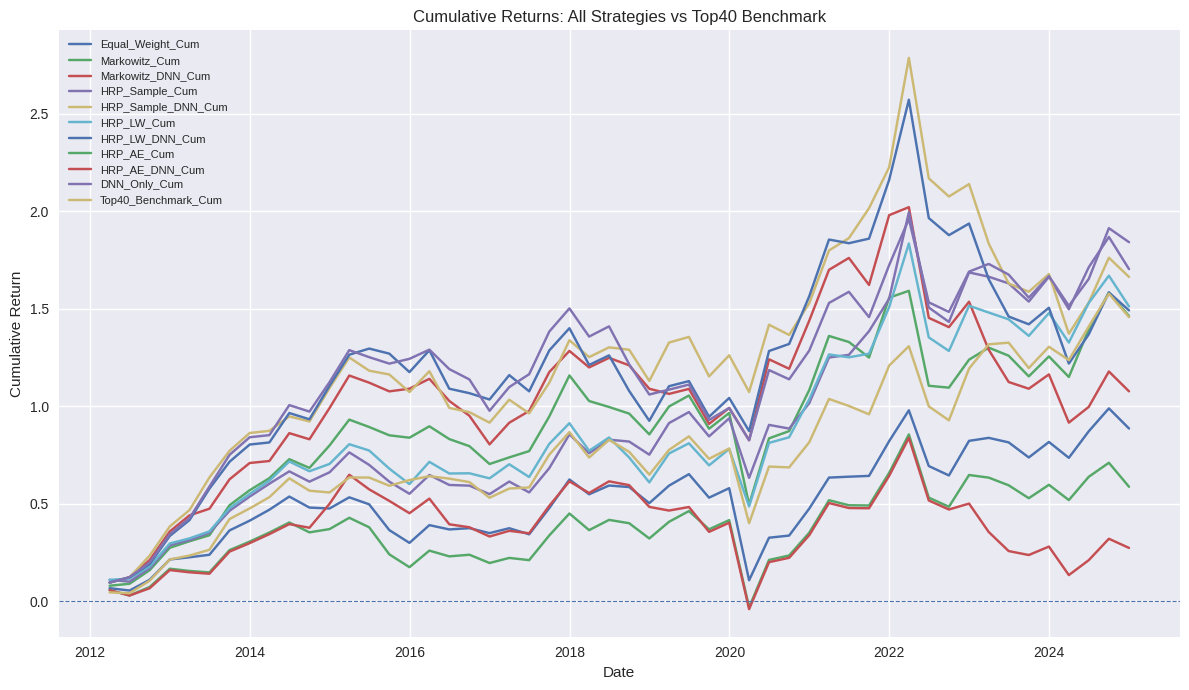

In [ ]:
def performance_stats(returns, periods_per_year=4, name="Strategy"):
    """
    Compute annualised performance statistics for a return series.
    Parameters
    ----------
    returns : pd.Series of quarterly returns
    periods_per_year : int, default 4 (quarterly data)
    """
    returns = returns.dropna()
    n = len(returns)
    if n == 0:
        return pd.Series(
            {"Ann.Return": np.nan, "Ann.Vol": np.nan, "Sharpe": np.nan},
            name=name
        )

    total_return = (1 + returns).prod() - 1

    ann_return = (1 + total_return) ** (periods_per_year / n) - 1

    ann_vol = returns.std(ddof=1) * np.sqrt(periods_per_year)

    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    return pd.Series(
        {"Ann.Return": ann_return, "Ann.Vol": ann_vol, "Sharpe": sharpe},
        name=name
    )



stats_list = []
for col in returns_all.columns:
    stats_list.append(performance_stats(returns_all[col], name=col))

perf_table = pd.DataFrame(stats_list)

perf_table = perf_table.sort_values("Sharpe", ascending=False)

print("=== Table 5.2 style performance summary (annualised, quarterly data) ===")
display(perf_table)


cum_all = (1 + returns_all).cumprod() - 1
cum_all.columns = [c + "_Cum" for c in cum_all.columns]

print("\nCumulative returns (head):")
display(cum_all.head())


benchmark_name = "Top40_Benchmark"
benchmark_ret = Y["Top40"].loc[returns_all.index]

benchmark_cum = (1 + benchmark_ret).cumprod() - 1
benchmark_cum = benchmark_cum.rename(benchmark_name + "_Cum")

cum_with_bench = cum_all.copy()
cum_with_bench[benchmark_name + "_Cum"] = benchmark_cum


plt.figure(figsize=(12, 7))

for col in cum_with_bench.columns:
    plt.plot(cum_with_bench.index, cum_with_bench[col], label=col)

plt.axhline(0, linestyle="--", linewidth=0.8)
plt.title("Cumulative Returns: All Strategies vs Top40 Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


## **Compute TRUE benchmarks (Top40, Sector-Average, Perfect-Foresight Best Sector)**

TRUE benchmark cumulative curves (head):


,Top40_Benchmark_Cum,Sector_Avg_Benchmark_Cum,Best_Sector_Perfect_Cum
Date,,,
2012-03-31,0.044273,0.065824,0.121425
2012-06-30,0.040159,0.053891,0.149339
2012-09-30,0.104068,0.108792,0.263126
2012-12-31,0.213120,0.213238,0.416235
2013-03-31,0.233234,0.224393,0.502576


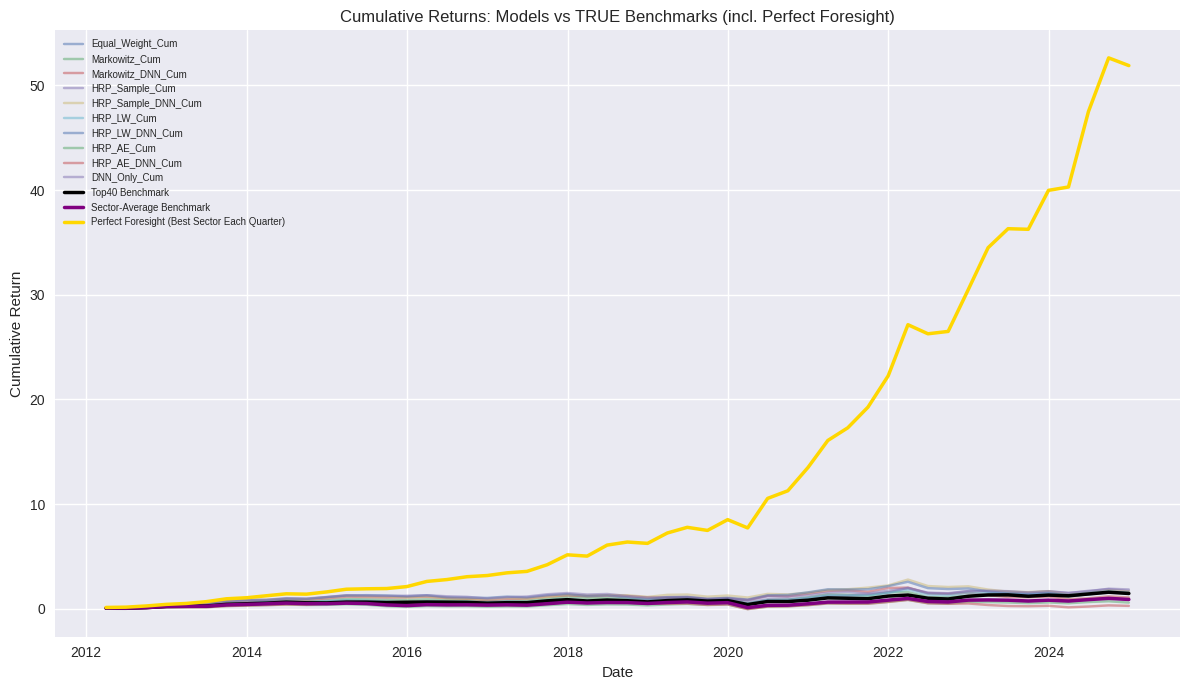

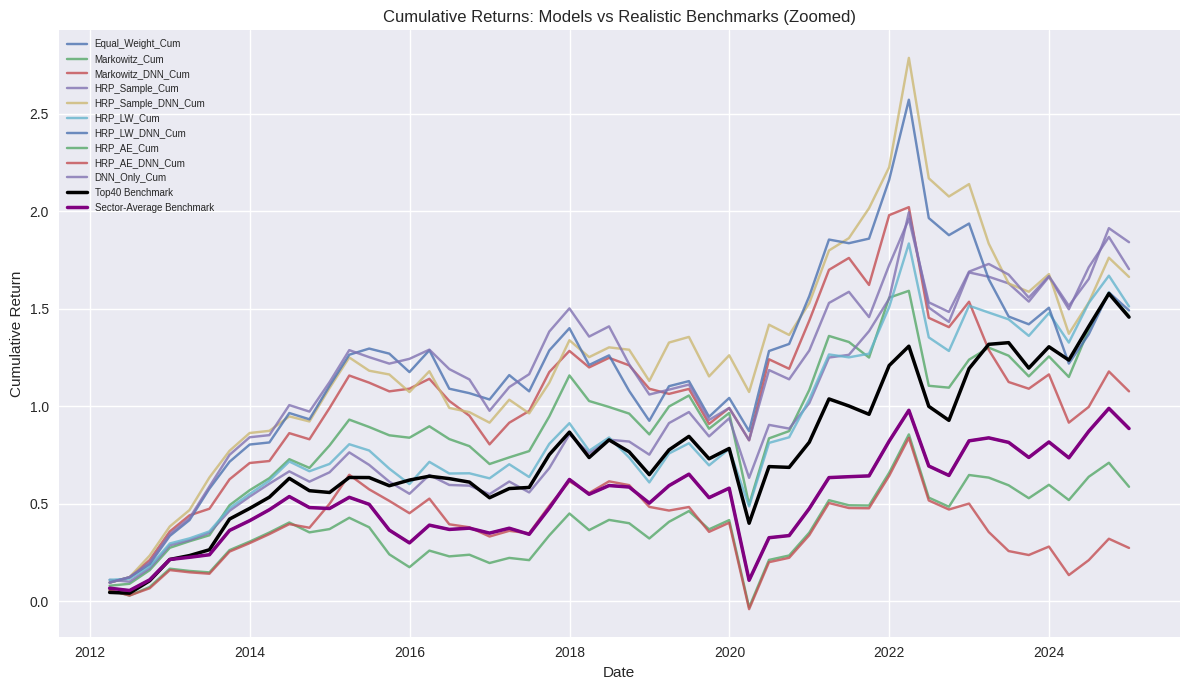

In [ ]:

bench_top40 = benchmark_cum.rename("Top40_Benchmark_Cum")


sector_avg_ret = Y.mean(axis=1).loc[returns_all.index]
sector_avg_cum = (1 + sector_avg_ret).cumprod() - 1
sector_avg_cum = sector_avg_cum.rename("Sector_Avg_Benchmark_Cum")


best_sector_ret = Y.loc[returns_all.index].max(axis=1)
best_sector_cum = (1 + best_sector_ret).cumprod() - 1
best_sector_cum = best_sector_cum.rename("Best_Sector_Perfect_Cum")

benchmarks_df = pd.concat([bench_top40, sector_avg_cum, best_sector_cum], axis=1)

print("TRUE benchmark cumulative curves (head):")
display(benchmarks_df.head())


plt.figure(figsize=(12, 7))


for col in cum_all.columns:
    plt.plot(cum_all.index, cum_all[col], label=col, alpha=0.5)


plt.plot(benchmarks_df.index, benchmarks_df["Top40_Benchmark_Cum"],
         label="Top40 Benchmark", linewidth=2.5, color="black")
plt.plot(benchmarks_df.index, benchmarks_df["Sector_Avg_Benchmark_Cum"],
         label="Sector-Average Benchmark", linewidth=2.5, color="purple")
plt.plot(benchmarks_df.index, benchmarks_df["Best_Sector_Perfect_Cum"],
         label="Perfect Foresight (Best Sector Each Quarter)",
         linewidth=2.5, color="gold")

plt.title("Cumulative Returns: Models vs TRUE Benchmarks (incl. Perfect Foresight)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left", fontsize=7)
plt.grid(True)
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 7))

for col in cum_all.columns:
    plt.plot(cum_all.index, cum_all[col], label=col, alpha=0.8)

plt.plot(benchmarks_df.index, benchmarks_df["Top40_Benchmark_Cum"],
         label="Top40 Benchmark", linewidth=2.5, color="black")
plt.plot(benchmarks_df.index, benchmarks_df["Sector_Avg_Benchmark_Cum"],
         label="Sector-Average Benchmark", linewidth=2.5, color="purple")

plt.title("Cumulative Returns: Models vs Realistic Benchmarks (Zoomed)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left", fontsize=7)
plt.grid(True)
plt.tight_layout()
plt.show()


## **Full Evaluation Suite: Ann.Return, Ann.Vol, Sharpe, Sortino, MaxDD, Turnover, Hit Ratio**

In [ ]:
def annualised_return(returns, periods_per_year=4):
    returns = returns.dropna()
    if len(returns) == 0:
        return np.nan
    total_return = (1 + returns).prod() - 1
    ann_return = (1 + total_return) ** (periods_per_year / len(returns)) - 1
    return ann_return


def annualised_volatility(returns, periods_per_year=4):
    returns = returns.dropna()
    if len(returns) == 0:
        return np.nan
    return returns.std(ddof=1) * np.sqrt(periods_per_year)


def sharpe_ratio(returns):
    vol = annualised_volatility(returns)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return annualised_return(returns) / vol


def sortino_ratio(returns, periods_per_year=4):
    downside = returns[returns < 0]
    if len(downside) == 0:
        return np.nan
    downside_dev = downside.std(ddof=1) * np.sqrt(periods_per_year)
    if downside_dev == 0 or np.isnan(downside_dev):
        return np.nan
    return annualised_return(returns) / downside_dev


def max_drawdown(cum_returns):
    running_max = cum_returns.cummax()
    dd = (cum_returns - running_max) / running_max
    return dd.min()


def turnover(weights_df):
    """
    weights_df: DataFrame indexed by Date with columns as sectors.
    """
    turnovers = []
    for i in range(1, len(weights_df)):
        prev_w = weights_df.iloc[i-1]
        curr_w = weights_df.iloc[i]
        turnovers.append(0.5 * np.abs(curr_w - prev_w).sum())
    if len(turnovers) == 0:
        return np.nan
    return np.mean(turnovers)


def hit_ratio(strategy_returns, benchmark_returns):
    """
    % of quarters where strategy beats benchmark.
    """
    comp = strategy_returns > benchmark_returns
    return comp.mean()


rows = []

for strat in returns_all.columns:
    r = returns_all[strat]
    cum = (1 + r).cumprod() - 1

    # weights
    w = weights_all[strat]

    metrics = {
        "Strategy": strat,
        "Ann.Return": annualised_return(r),
        "Ann.Vol": annualised_volatility(r),
        "Sharpe": sharpe_ratio(r),
        "Sortino": sortino_ratio(r),
        "MaxDD": max_drawdown(cum),
        "Turnover": turnover(w),
        # Hit ratio vs Top40 benchmark
        "HitRatio_vs_Top40": hit_ratio(r, returns_all["Equal_Weight"])  # you can change the benchmark later
    }

    rows.append(metrics)

metrics_df = pd.DataFrame(rows).set_index("Strategy")

print("===== Full Metrics Table (7 Metrics) =====")
display(metrics_df)


===== Full Metrics Table (7 Metrics) =====


,Ann.Return,Ann.Vol,Sharpe,Sortino,MaxDD,Turnover,HitRatio_vs_Top40
Strategy,,,,,,,
Equal_Weight,0.049972,0.153106,0.326392,0.375052,-0.836571,0.000000,0.000000
Markowitz,0.071771,0.156392,0.458918,0.613543,-0.572717,0.349168,0.634615
Markowitz_DNN,0.057788,0.149187,0.387350,0.668861,-0.547050,0.415140,0.557692
HRP_Sample,0.079491,0.138130,0.575482,0.944988,-0.348138,0.250296,0.538462
HRP_Sample_DNN,0.078246,0.146488,0.534146,0.945533,-0.507916,0.398816,0.461538
HRP_LW,0.073405,0.147073,0.499106,0.828613,-0.468001,0.178003,0.634615
HRP_LW_DNN,0.072731,0.154003,0.472271,0.845852,-0.526290,0.323429,0.557692
HRP_AE,0.036123,0.168055,0.214945,0.267679,-1.070530,0.096193,0.403846
HRP_AE_DNN,0.018700,0.173405,0.107839,0.138933,-1.064466,0.245187,0.365385


===== Ranking Table (1 = Best) =====


,Ann.Return,Ann.Vol,Sharpe,Sortino,MaxDD,Turnover,HitRatio_vs_Top40,TotalScore
Strategy,,,,,,,,
DNN_Only,1,1,1,1,2,4,6,16
HRP_Sample,2,2,2,3,1,6,5,21
HRP_LW,4,4,4,5,3,3,1,24
HRP_Sample_DNN,3,3,3,2,4,9,6,30
HRP_LW_DNN,5,7,5,4,5,7,3,36
Markowitz,6,8,6,7,7,8,1,43
Markowitz_DNN,7,5,7,6,6,10,3,44
Equal_Weight,8,6,8,8,8,1,10,49
HRP_AE,9,9,9,9,10,2,8,56


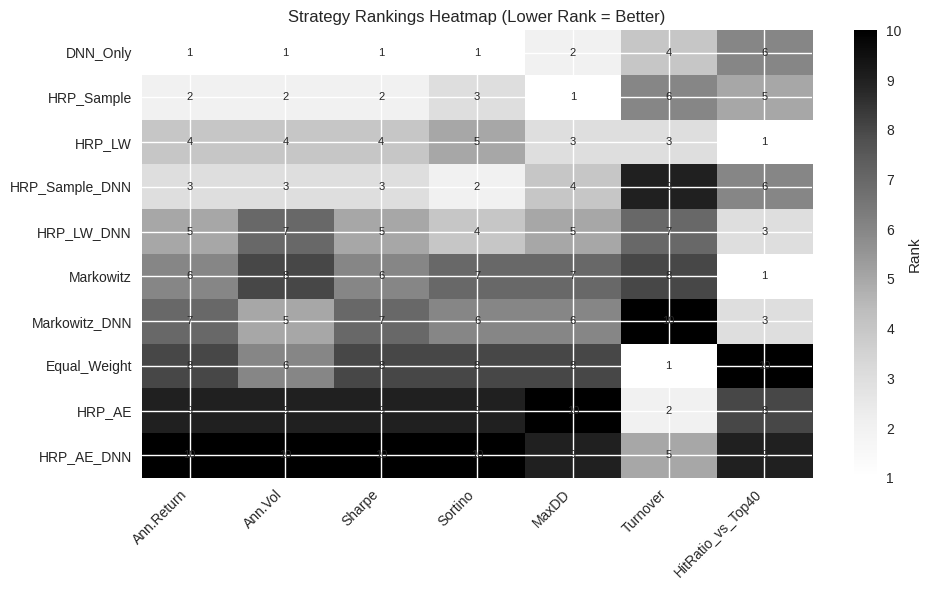

Top 3 strategies by TotalScore: ['DNN_Only', 'HRP_Sample', 'HRP_LW']


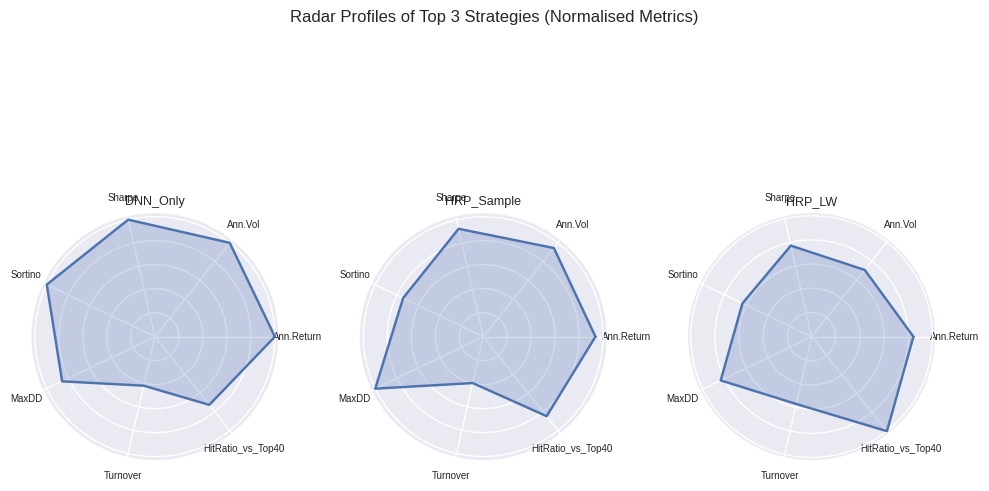

In [ ]:
metrics_cols = [
    "Ann.Return",
    "Ann.Vol",
    "Sharpe",
    "Sortino",
    "MaxDD",
    "Turnover",
    "HitRatio_vs_Top40",
]

metrics_used = metrics_df[metrics_cols].copy()

minimize = {
    "Ann.Return": False,
    "Ann.Vol": True,
    "Sharpe": False,
    "Sortino": False,
    "MaxDD": False,
    "Turnover": True,
    "HitRatio_vs_Top40": False,
}

ranks = pd.DataFrame(index=metrics_used.index)

for col in metrics_cols:
    asc = minimize[col]
    ranks[col] = metrics_used[col].rank(ascending=asc, method="min").astype(int)


ranks["TotalScore"] = ranks.sum(axis=1)


ranks_sorted = ranks.sort_values("TotalScore")

print("===== Ranking Table (1 = Best) =====")
display(ranks_sorted)


plt.figure(figsize=(10, 6))


heat_data = ranks_sorted[metrics_cols]

plt.imshow(heat_data.values, aspect="auto")

plt.xticks(range(len(metrics_cols)), metrics_cols, rotation=45, ha="right")
plt.yticks(range(len(heat_data.index)), heat_data.index)

for i in range(heat_data.shape[0]):
    for j in range(heat_data.shape[1]):
        val = heat_data.iloc[i, j]
        plt.text(j, i, str(val), ha="center", va="center", fontsize=8)

plt.title("Strategy Rankings Heatmap (Lower Rank = Better)")
plt.colorbar(label="Rank")
plt.tight_layout()
plt.show()


top_strats = ranks_sorted.index[:3].tolist()
print("Top 3 strategies by TotalScore:", top_strats)


norm_metrics = metrics_used.copy()

for col in metrics_cols:
    vals = norm_metrics[col]
    if minimize[col]:

        vals = -vals

    vmin, vmax = vals.min(), vals.max()
    if vmax - vmin != 0:
        norm_metrics[col] = (vals - vmin) / (vmax - vmin)
    else:
        norm_metrics[col] = 0.5


labels = metrics_cols
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)
angles = np.concatenate([angles, [angles[0]]])

plt.figure(figsize=(10, 6))

for strat in top_strats:
    values = norm_metrics.loc[strat, labels].values

    values = np.concatenate([values, [values[0]]])

    ax = plt.subplot(1, 3, top_strats.index(strat) + 1, polar=True)
    ax.plot(angles, values)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=7)
    ax.set_yticklabels([])
    ax.set_title(strat, fontsize=9)

plt.suptitle("Radar Profiles of Top 3 Strategies (Normalised Metrics)", y=1.02)
plt.tight_layout()
plt.show()
